## Control Variables
- Resolution = 0.25
- ROBOT_RADIUS = 0.25
- NUM_OF_AGENT = 10

- Vary num_of agent
- Vary Samples
- Vary Dataset 

### Random, no Optimiser

In [1]:
import BayesianOptimisation.randVoronoiDirected as randVoronoiDirected
import BayesianOptimisation.experiment_setup as experiment
from core.DataStructure import *

from importlib import reload
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import copy
import itertools

from scipy.optimize import minimize, Bounds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Reshape
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import time
from sklearn.preprocessing import MinMaxScaler
import os 

np.random.seed(9) 
COLOUR = itertools.cycle(['#00FFFF', '#6495ED', '#89CFF0', '#0000FF', '#7393B3', '#088F8F', 
                          '#0096FF', '#0047AB', '#00FFFF', '#00008B', '#6F8FAF',
                          '#1434A4', '#7DF9FF', '#6082B6', '#00A36C', '#5D3FD3',
                          '#ADD8E6'])

### Generating Data

In [2]:
# Updated Get Coverage, take into account of obs now
def getCoverage(exp, G, directed = False, save_fig_path = None):
    total_area = 0
    total_dist = 0
    assigned = {}
    fig, ax = plt.subplots(figsize=(6,6))
    plt.xlim(0,exp.image.shape[1])
    plt.ylim(0,exp.image.shape[0])
    count = 0
    
    for o in exp.obstacles_loc:
        adjustedx, adjustedy = o[1],o[0]
        rect = Rectangle((adjustedx-0.5,adjustedy-0.5),1,1,linewidth=0.1,fill=True, angle = 0, color = 'black')
        plt.gca().add_patch(rect)
    im = fig
    im.canvas.draw()
    X = np.array(im.canvas.renderer._renderer)
    X_reshape = X.reshape((-1,4))
    X_reshape = np.delete(X_reshape, [1,2,3], axis = 1)
    obs_black = np.count_nonzero(X_reshape == 0)
#     print("Obstacle Black", obs_black)
    
    for n in G.nodes:
        for e in G.neighbors(n):
            if n != e and frozenset((n, e)) not in assigned.keys():
                
                p1 = G.nodes[n]['position']
                p2 = G.nodes[e]['position']
                
                if (directed):
                    d = G.edges[n,e,0]['distance']
                    c = G.edges[n,e,0]['capacity']*exp.ROBOT_RADIUS
                else:
                    d = G.edges[n,e]['distance']
                    c = G.edges[n,e]['capacity']*exp.ROBOT_RADIUS
                
                
                assigned[frozenset((n, e))] = 1

                adjustp1 = Point(p1.y, p1.x)
                adjustp2 = Point(p2.y, p2.x)

                refpt1 = adjustp1 if adjustp1.y <= adjustp2.y else adjustp2
                refpt2 = adjustp1 if adjustp1.y > adjustp2.y else adjustp2

                if refpt1.x >= refpt2.x:
                    theta_rot = np.pi - np.arctan(abs(refpt1.y - refpt2.y)/abs(refpt1.x - refpt2.x))
                else:
                    theta_rot = np.arctan(abs(refpt1.y - refpt2.y)/abs(refpt1.x - refpt2.x))

                if theta_rot >= np.pi/2:
                    theta = theta_rot - np.pi/2
                else:
                    theta = theta_rot + np.pi/2

                dy = -(c/2)*np.sin(theta)
                if refpt1.y == refpt2.y:
                    dx = 0
                    width = d
                    height = c
                    a = 0
                elif refpt1.x > refpt2.x:
                    dx = -(c/2)*np.cos(theta)
                    width = c
                    height = d
                    a = (theta) * 180 / np.pi
                elif refpt1.x == refpt2.x:
                    dx = -(c/2)
                    width = c
                    height = d
                    a = 0
                else:
                    dx = (c/2)*np.cos(np.pi - theta)
                    width = d
                    height = c
                    a = (theta_rot) * 180 / np.pi
                    
                print_colour = 'blue' if save_fig_path != None else 'black'
                rect = Rectangle((refpt1.x+dx,refpt1.y+dy),width,height,linewidth=0.1,fill=True, angle = a,color = print_colour )
                plt.gca().add_patch(rect)
                count +=1

    ax.axis('off')
    if save_fig_path != None:
        plt.savefig(save_fig_path)

    im = fig
    im.canvas.draw()
    X = np.array(im.canvas.renderer._renderer)
    X_reshape = X.reshape((-1,4))
    X_reshape = np.delete(X_reshape, [1,2,3], axis = 1)
    black = np.count_nonzero(X_reshape == 0)
    white= np.count_nonzero(X_reshape == 255)
#     print("Black px", black, "White px", white)
    percentage = (black-obs_black)/(white+black-obs_black)
#     print("U2", percentage)
    return percentage

In [3]:
def showVorDirSolution(
    result_graph, 
    paths,
    exp,
    save_fig_path = None):
    
    fig, ax = plt.subplots(figsize=(12,12))
    img = np.array(1-exp.image)
    ax = sb.heatmap(img)
    colors = copy.deepcopy(COLOUR)
    
    assigned = {}
    scaler = 0.2
    for elem in result_graph.edges:
        cur = result_graph.edges[elem[0], elem[1], 0]['probability']
        opposite = result_graph.edges[elem[1], elem[0], 0]['probability']
        if cur > opposite:
            p1 = result_graph.nodes[elem[0]]['position']
            arr1 = np.array([p1.x,p1.y])
            p2 = result_graph.nodes[elem[1]]['position']
            arr2 = np.array([p2.x,p2.y])
            direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
            mag = np.linalg.norm(arr2 - arr1)*scaler
            dx, dy = mag*direction
        else:
            p1 = result_graph.nodes[elem[1]]['position']
            arr1 = np.array([p1.x,p1.y])
            p2 = result_graph.nodes[elem[0]]['position']
            arr2 = np.array([p2.x,p2.y])
            direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
            mag = np.linalg.norm(arr2 - arr1)*scaler
            dx, dy = mag*direction

        # only draw arrow once
        if frozenset((p1.y, p1.x, dy, dx)) not in assigned.keys():
            head_width = 0.1 if mag < 0.2 else 0.35
            plt.plot([p1.y,p2.y], [p1.x, p2.x],color = "grey", linewidth=1)
            plt.arrow(p1.y, p1.x, dy, dx, head_width = head_width, alpha=0.9, color = "grey", linewidth=0.1)
            assigned[frozenset((p1.y, p1.x, dy, dx))] = 1
        
        
    for p in exp.start_nodes:
        plt.scatter(exp.nodes[p].y, exp.nodes[p].x, s=80, facecolors='none', edgecolors='r')
    for p in exp.end_nodes:
        plt.scatter(exp.nodes[p].y, exp.nodes[p].x, s=80, facecolors='r', edgecolors='r')

    plt.gca().invert_yaxis()
    plt.savefig(save_fig_path)

In [4]:
def showVorDirSolutionAcc(
    result_graph, 
    paths, image, 
    nodes, 
    start_nodes, 
    end_nodes, 
    all_path = True, 
    path_num = 0,
    save_fig_path = None, 
    exp=None):
    
    image2 = 1-image
    fig, ax = plt.subplots(figsize=(12,12))
    img = np.array(1-exp.image)
    ax = sb.heatmap(img)
    colors = copy.deepcopy(COLOUR)
    
    edges_in_path = []
    assigned = {}
    drawn = {}
    
    for index, path in enumerate(paths):
        colour = next(colors)
        for ite in range(len(path)-1):
            edges_in_path.append(np.array([path[ite],path[ite+1],0]))
            p1 = result_graph.nodes[path[ite]]['position']
            p2 = result_graph.nodes[path[ite+1]]['position']

            for r in (p1.x, p2.x, 1):
                for c in (p1.y, p2.y, 1):
                    if (Point(r,c) in np.array(nodes)[end_nodes]):
                        image2[int(r),int(c)] = 1
                    else:
                        image2[int(r),int(c)] += 0.2

        loop = result_graph.edges if all_path else edges_in_path
        for elem in loop:
            cur = result_graph.edges[elem[0], elem[1], 0]['probability']
            opposite = result_graph.edges[elem[1], elem[0], 0]['probability']
            unused = 1 - cur - opposite
            scaler = 0.8
            if cur > opposite:
                p1 = result_graph.nodes[elem[0]]['position']
                arr1 = np.array([p1.x,p1.y])
                p2 = result_graph.nodes[elem[1]]['position']
                arr2 = np.array([p2.x,p2.y])
                direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
                mag = np.linalg.norm(arr2 - arr1)*scaler
                dx, dy = mag*direction
            else:
                p1 = result_graph.nodes[elem[1]]['position']
                arr1 = np.array([p1.x,p1.y])
                p2 = result_graph.nodes[elem[0]]['position']
                arr2 = np.array([p2.x,p2.y])
                direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
                mag = np.linalg.norm(arr2 - arr1)*scaler
                dx, dy = mag*direction
            
            # only draw arrow once
            if frozenset((p1.y, p1.x, dy, dx)) not in assigned.keys() and frozenset([elem[0], elem[1]]) not in drawn:
                head_width = 0.1 if mag < 0.2 else 0.35
                plt.plot([p1.y,p2.y], [p1.x, p2.x],color = colour, linewidth=1)
                plt.arrow(p1.y, p1.x, dy, dx, head_width = head_width, alpha=0.9, color = colour, linewidth=0.1)
                assigned[frozenset((p1.y, p1.x, dy, dx))] = 1
                drawn[frozenset([elem[0], elem[1]])] = 1
                
    #draw all other arrow
    scaler = 0.8
    for elem in result_graph.edges:
        cur = result_graph.edges[elem[0], elem[1], 0]['probability']
        opposite = result_graph.edges[elem[1], elem[0], 0]['probability']
        if cur > opposite:
            p1 = result_graph.nodes[elem[0]]['position']
            arr1 = np.array([p1.x,p1.y])
            p2 = result_graph.nodes[elem[1]]['position']
            arr2 = np.array([p2.x,p2.y])
            direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
            mag = np.linalg.norm(arr2 - arr1)*scaler
            dx, dy = mag*direction
        else:
            p1 = result_graph.nodes[elem[1]]['position']
            arr1 = np.array([p1.x,p1.y])
            p2 = result_graph.nodes[elem[0]]['position']
            arr2 = np.array([p2.x,p2.y])
            direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
            mag = np.linalg.norm(arr2 - arr1)*scaler
            dx, dy = mag*direction

        # only draw arrow once
        if frozenset((p1.y, p1.x, dy, dx)) not in assigned.keys() and frozenset([elem[0], elem[1]]) not in drawn:
            head_width = 0.1 if mag < 0.5 else 0.35
            plt.plot([p1.y,p2.y], [p1.x, p2.x],color = "grey", linewidth=1)
            plt.arrow(p1.y, p1.x, dy, dx, head_width = head_width, alpha=0.9, color = "grey", linewidth=0.1)
            assigned[frozenset((p1.y, p1.x, dy, dx))] = 1
            drawn[frozenset([elem[0], elem[1]])] = 1
        
    for p in exp.start_nodes:
        plt.scatter(exp.nodes[p].y, exp.nodes[p].x, s=120, facecolors='none', edgecolors='r')
    for p in exp.end_nodes:
        plt.scatter(exp.nodes[p].y, exp.nodes[p].x, s=120, facecolors='r', edgecolors='r')

    plt.gca().invert_yaxis()
    plt.savefig(save_fig_path)

In [5]:
def showVorDirSolutionPath(
    result_graph, 
    paths, image, 
    nodes, 
    start_nodes, 
    end_nodes, 
    all_path = True, 
    path_num = 0,
    save_fig_path = None):
    
    image2 = 1-image
    fig, ax = plt.subplots(figsize=(12,12))
    img = np.array(1-image)
    ax = sb.heatmap(img)
    colors = copy.deepcopy(COLOUR)
    
    edges_in_path = []
    assigned = {}
    drawn = {}
    
    for index, path in enumerate(paths):
        colour = next(colors)
        for ite in range(len(path)-1):
            edges_in_path.append(np.array([path[ite],path[ite+1],0]))
            p1 = result_graph.nodes[path[ite]]['position']
            p2 = result_graph.nodes[path[ite+1]]['position']

            for r in (p1.x, p2.x, 1):
                for c in (p1.y, p2.y, 1):
                    if (Point(r,c) in np.array(nodes)[end_nodes]):
                        image2[int(r),int(c)] = 1
                    else:
                        image2[int(r),int(c)] += 0.2

        loop = result_graph.edges if all_path else edges_in_path

        for elem in loop:
            cur = result_graph.edges[elem[0], elem[1], 0]['probability']
            opposite = result_graph.edges[elem[1], elem[0], 0]['probability']
            unused = 1 - cur - opposite
            scaler = 0.8
            if cur > opposite:
                p1 = result_graph.nodes[elem[0]]['position']
                arr1 = np.array([p1.x,p1.y])
                p2 = result_graph.nodes[elem[1]]['position']
                arr2 = np.array([p2.x,p2.y])
                direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
                mag = np.linalg.norm(arr2 - arr1)*scaler
                dx, dy = mag*direction
            else:
                p1 = result_graph.nodes[elem[1]]['position']
                arr1 = np.array([p1.x,p1.y])
                p2 = result_graph.nodes[elem[0]]['position']
                arr2 = np.array([p2.x,p2.y])
                direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
                mag = np.linalg.norm(arr2 - arr1)*scaler
                dx, dy = mag*direction
            
            # only draw arrow once
            if frozenset((p1.y, p1.x, dy, dx)) not in assigned.keys() and frozenset([elem[0], elem[1]]) not in drawn:
                head_width = 0.1 if mag < 0.2 else 0.35
                plt.plot([p1.y,p2.y], [p1.x, p2.x],color = colour, linewidth=1)
                plt.arrow(p1.y, p1.x, dy, dx, head_width = head_width, alpha=0.9, color = colour, linewidth=0.1)
                assigned[frozenset((p1.y, p1.x, dy, dx))] = 1
                drawn[frozenset([elem[0], elem[1]])] = 1
        
    for p in exp.start_nodes:
        plt.scatter(exp.nodes[p].y, exp.nodes[p].x, s=80, facecolors='none', edgecolors='r')
    for p in exp.end_nodes:
        plt.scatter(exp.nodes[p].y, exp.nodes[p].x, s=80, facecolors='r', edgecolors='r')

    plt.gca().invert_yaxis()
    plt.savefig(save_fig_path)

## Main

In [6]:
results_array = []

Seed List [92]
Successfully created the directory ./data/Random/4agent/Dataset1/Seed92/ 
Set Hyper Parameters, solving for 4 agents
total number of distance 186
Saving Data to ./data/Random/4agent/Dataset1/Seed92/x_path.csv
total number of distance 186
Finish generating data
Start Visualise
total number of distance 186
Number of trainable probabilities 172
Length cutoff threshold 2


/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in double_scalars
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in true_divide


total number of distance 186
Number of trainable probabilities 172
Length cutoff threshold 2
Done
Seed List [65]
Successfully created the directory ./data/Random/4agent/Dataset2/Seed65/ 
Set Hyper Parameters, solving for 4 agents
total number of distance 185
Saving Data to ./data/Random/4agent/Dataset2/Seed65/x_path.csv
total number of distance 185
Finish generating data
Start Visualise
total number of distance 185
Number of trainable probabilities 171
Length cutoff threshold 2
total number of distance 185
Number of trainable probabilities 171
Length cutoff threshold 2


/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


Done
Seed List [63]
Successfully created the directory ./data/Random/4agent/Dataset3/Seed63/ 
Set Hyper Parameters, solving for 4 agents
total number of distance 185
Saving Data to ./data/Random/4agent/Dataset3/Seed63/x_path.csv
total number of distance 185
Finish generating data
Start Visualise
total number of distance 185
Number of trainable probabilities 170
Length cutoff threshold 2

Cannot find complete solution. Some didnt reach goal

total number of distance 185
Number of trainable probabilities 170
Length cutoff threshold 2

Cannot find complete solution. Some didnt reach goal

Done
Seed List [97]
Successfully created the directory ./data/Random/4agent/Dataset4/Seed97/ 
Set Hyper Parameters, solving for 4 agents
total number of distance 185
Saving Data to ./data/Random/4agent/Dataset4/Seed97/x_path.csv
total number of distance 185
Finish generating data
Start Visualise
total number of distance 185
Number of trainable probabilities 171
Length cutoff threshold 2
total number of d

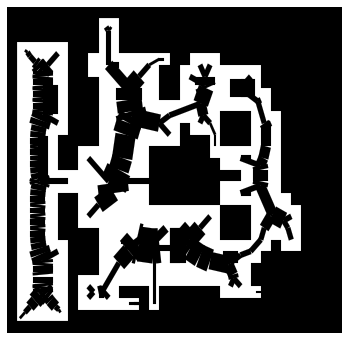

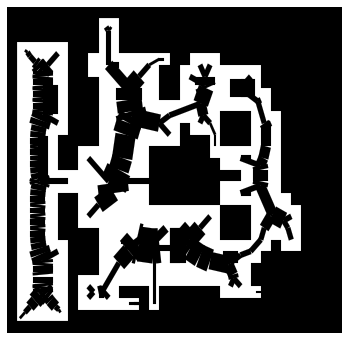

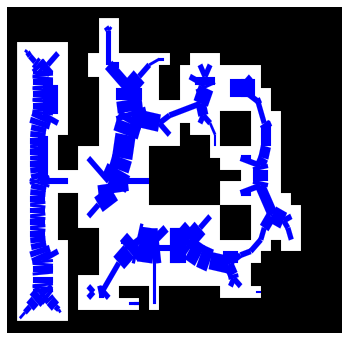

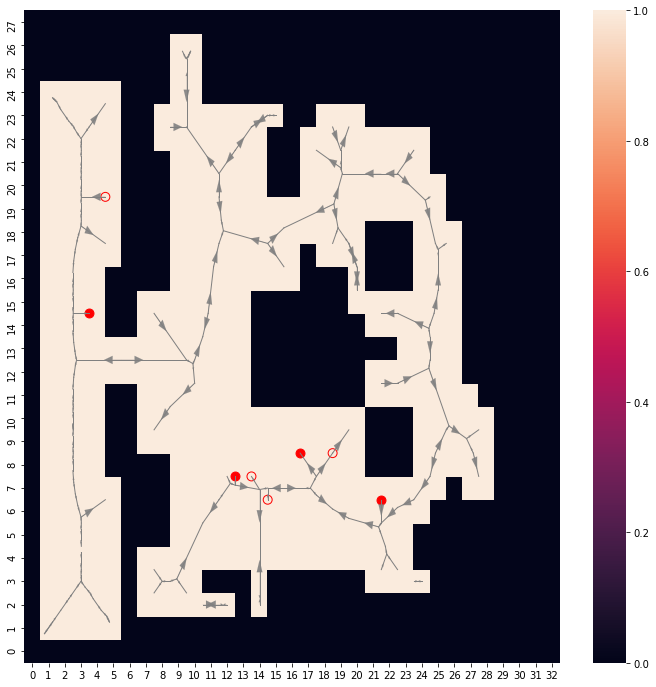

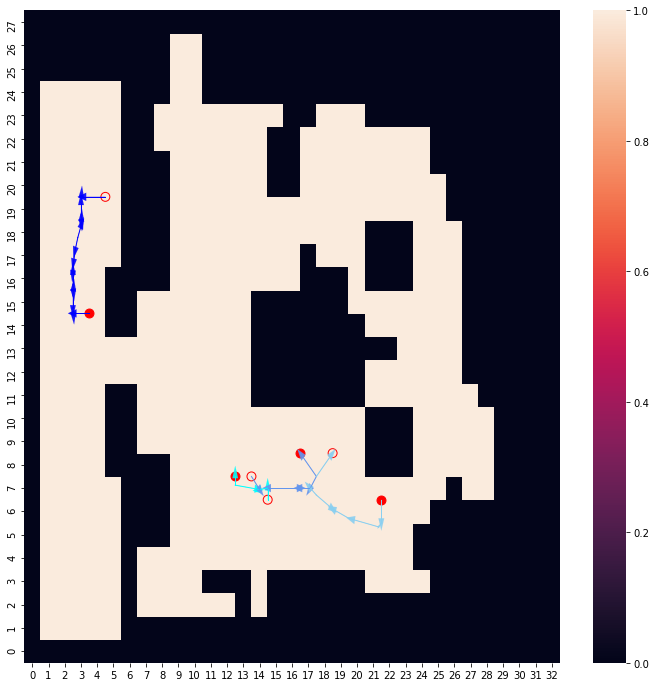

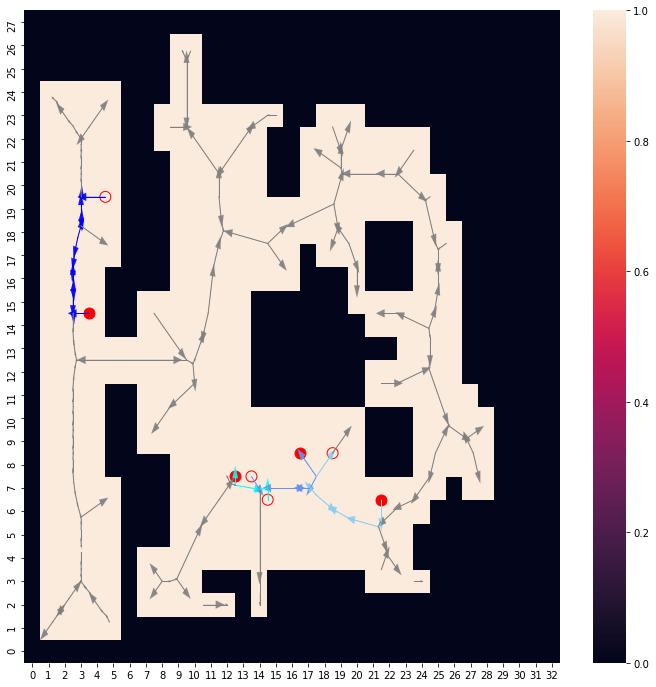

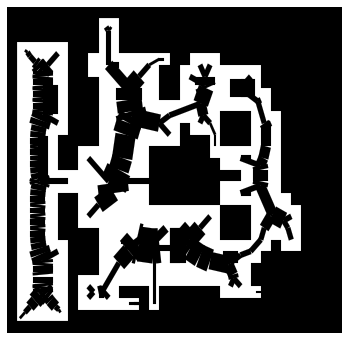

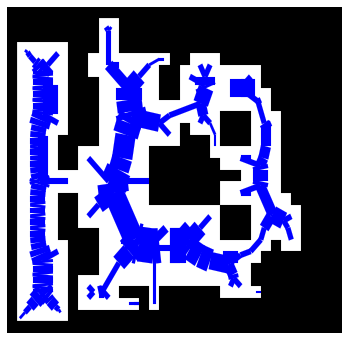

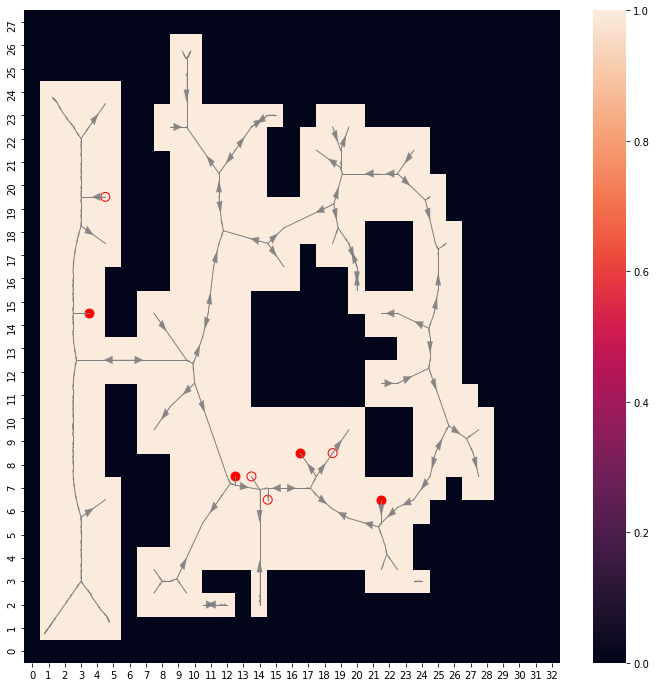

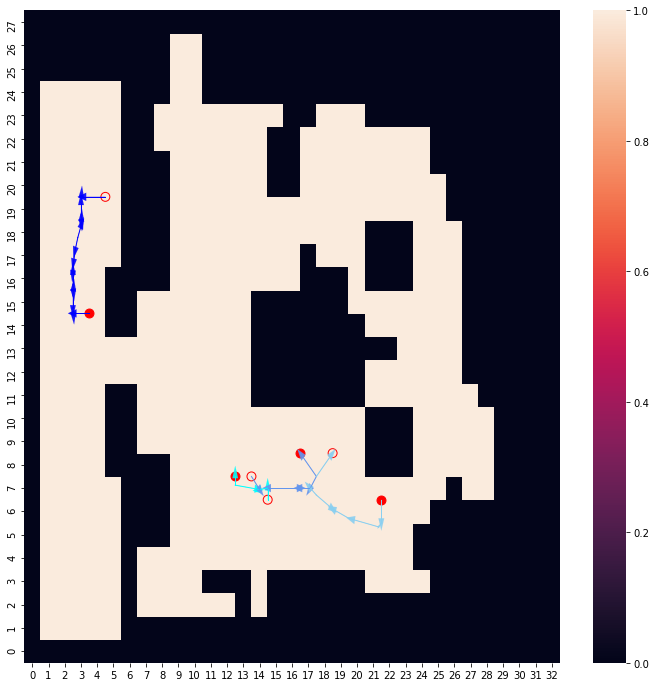

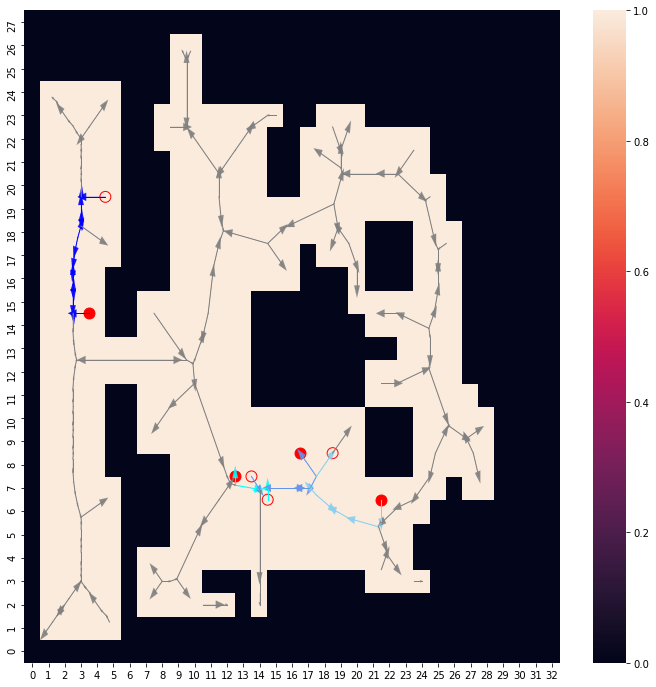

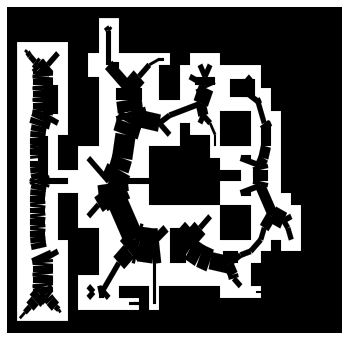

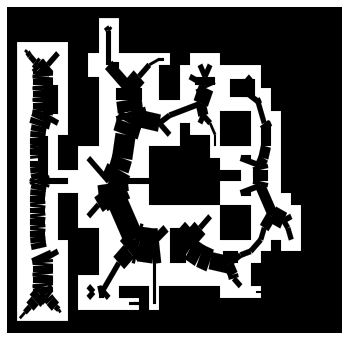

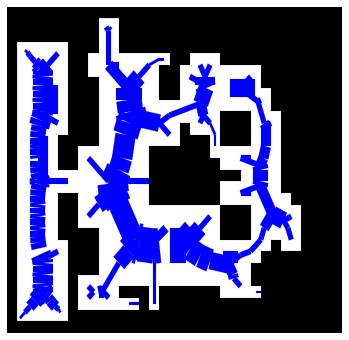

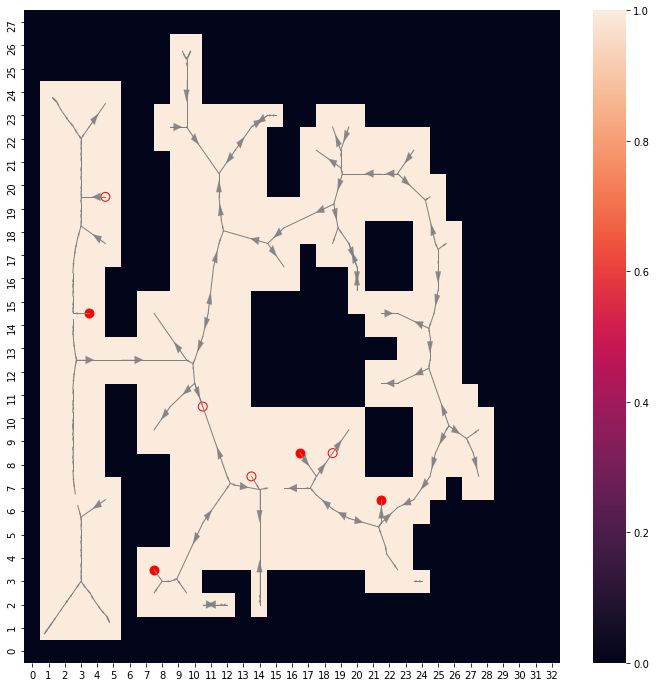

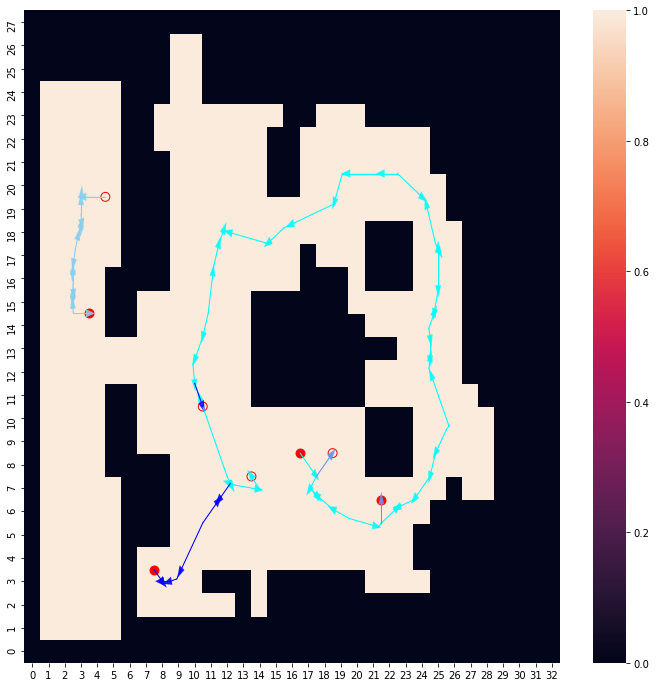

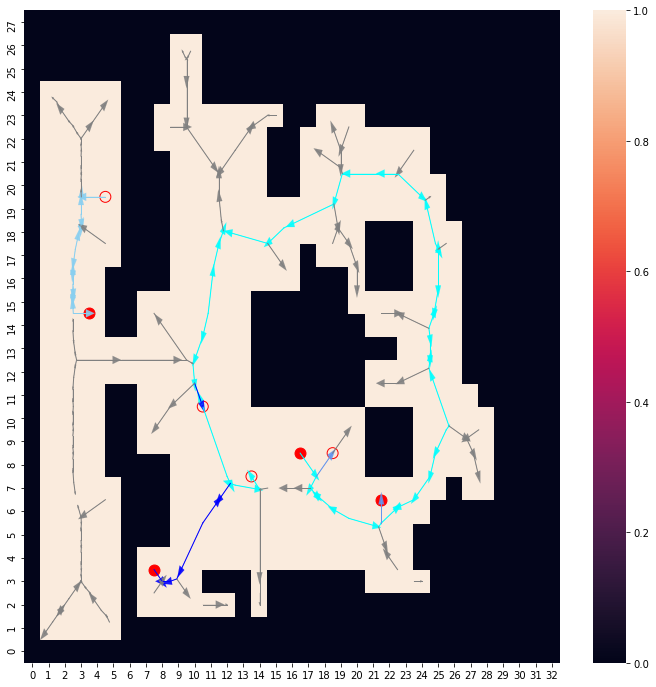

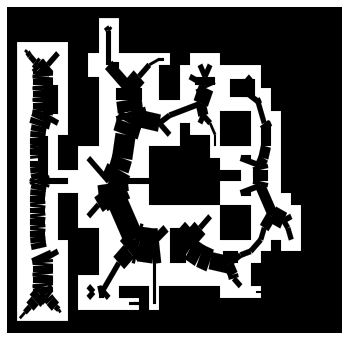

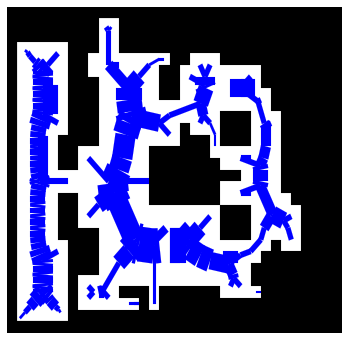

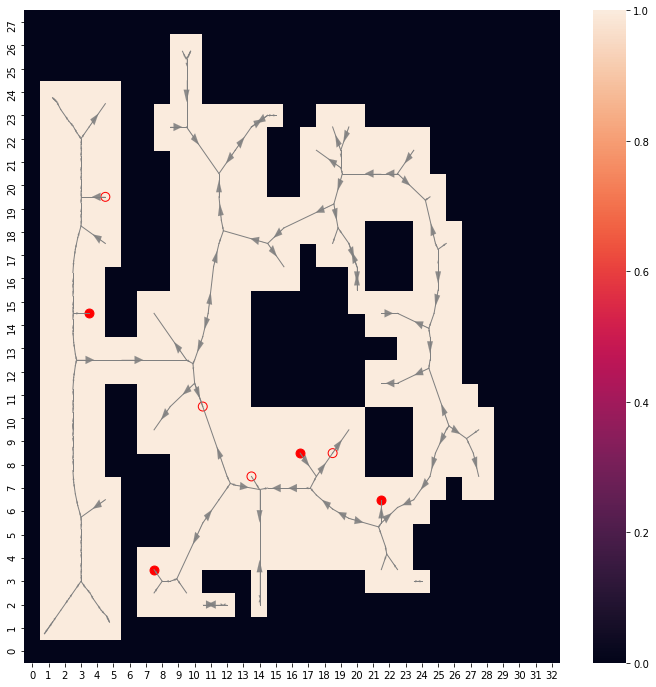

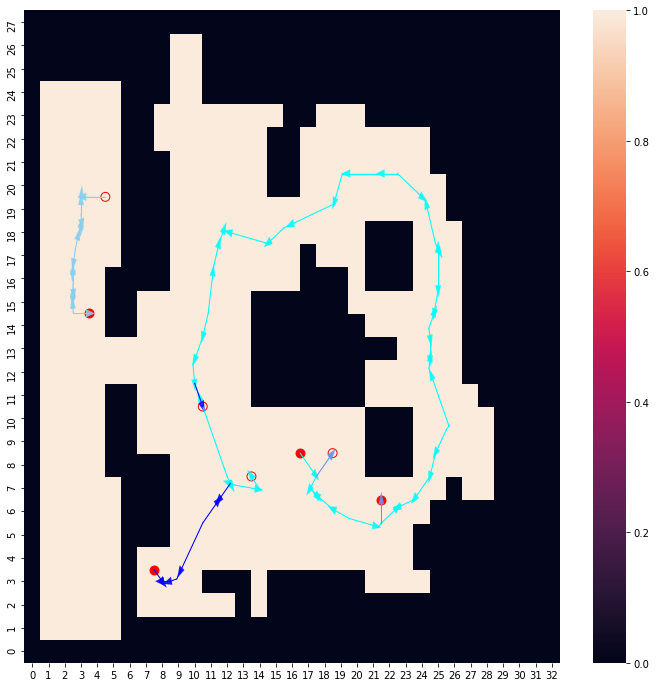

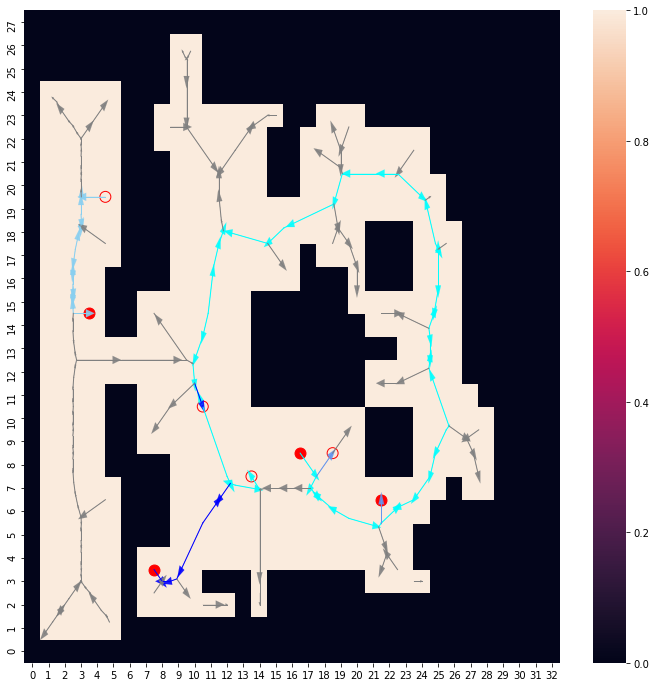

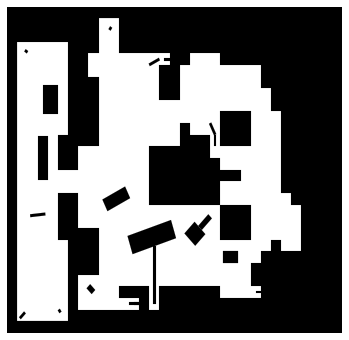

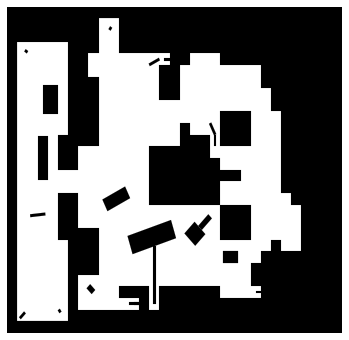

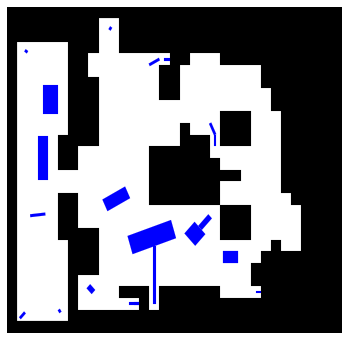

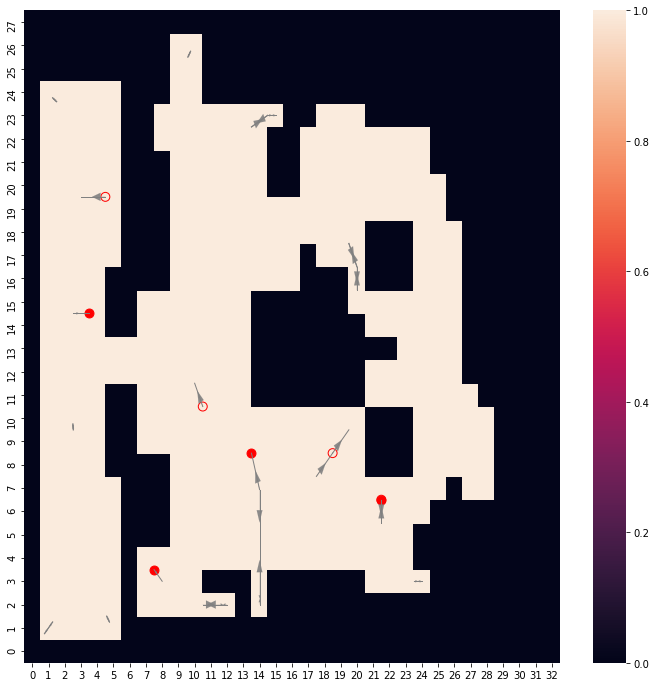

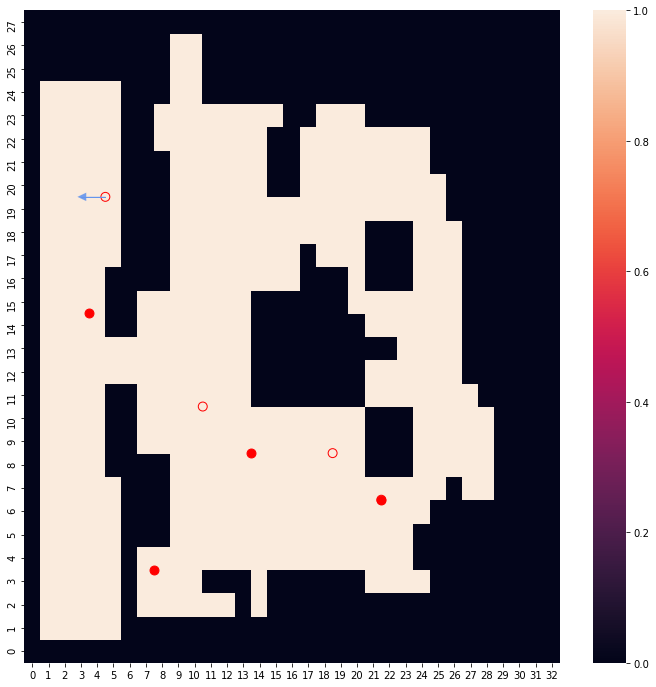

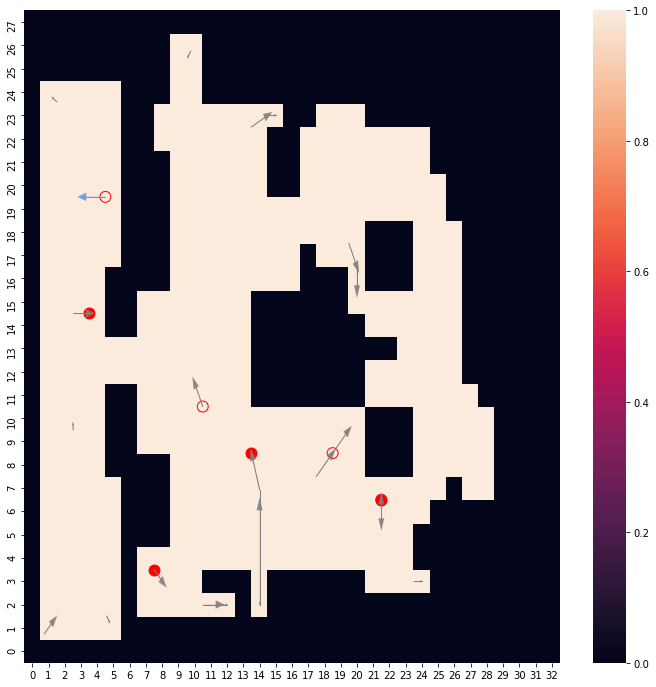

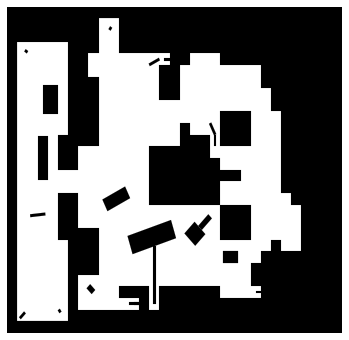

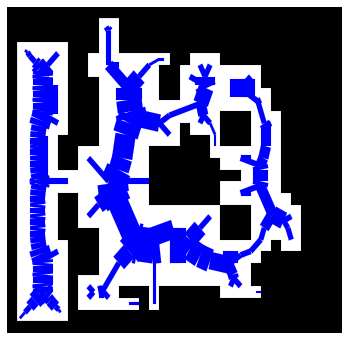

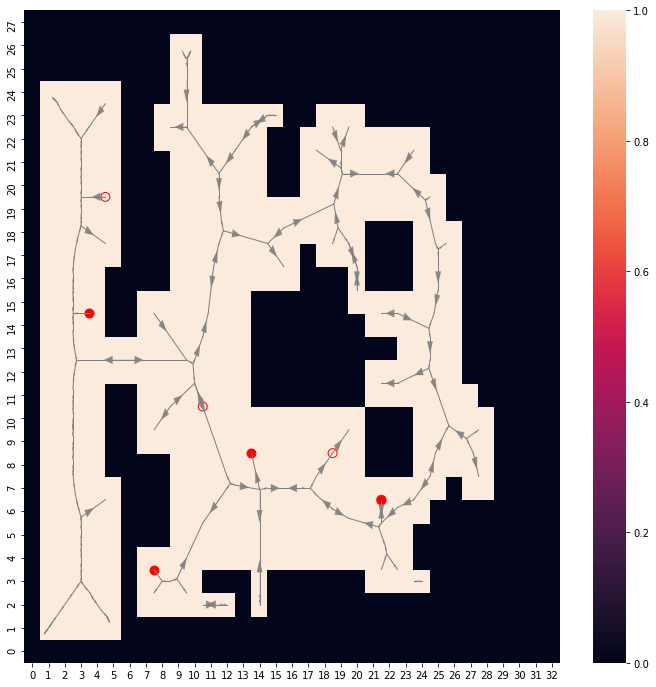

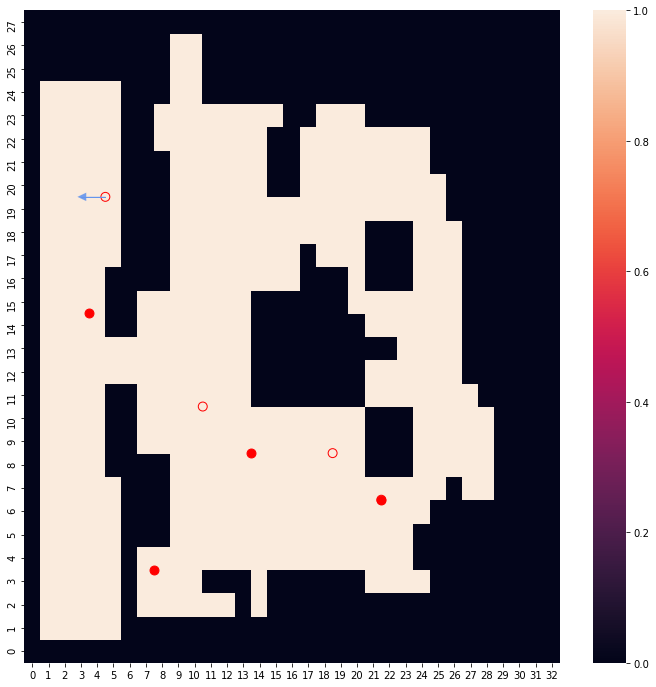

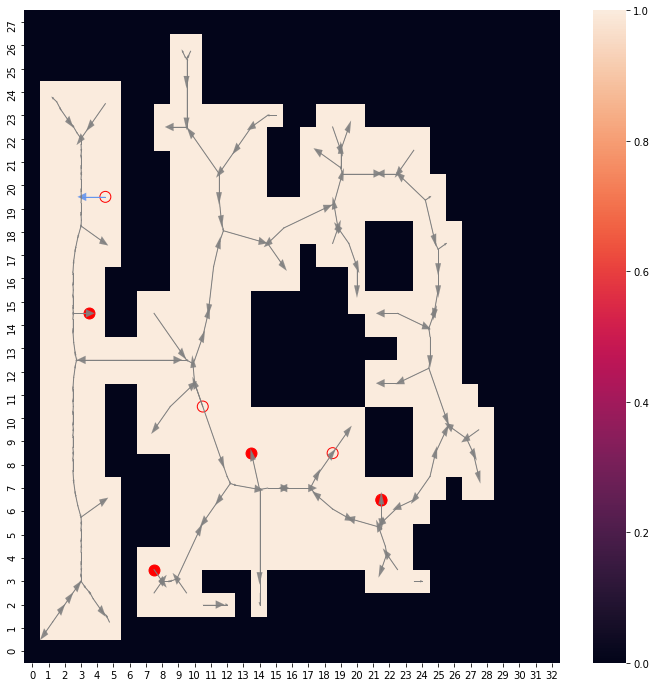

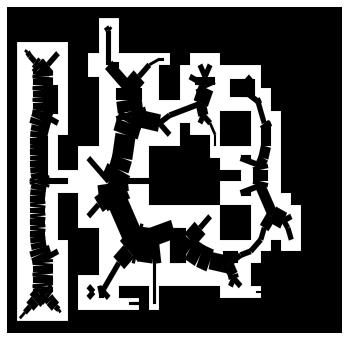

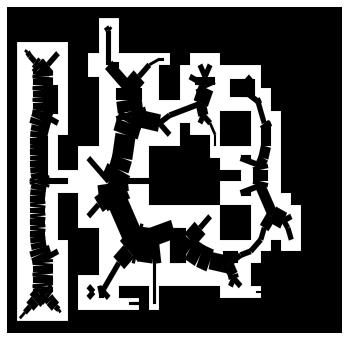

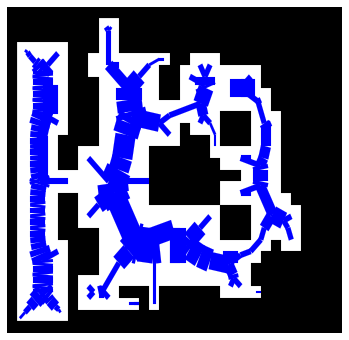

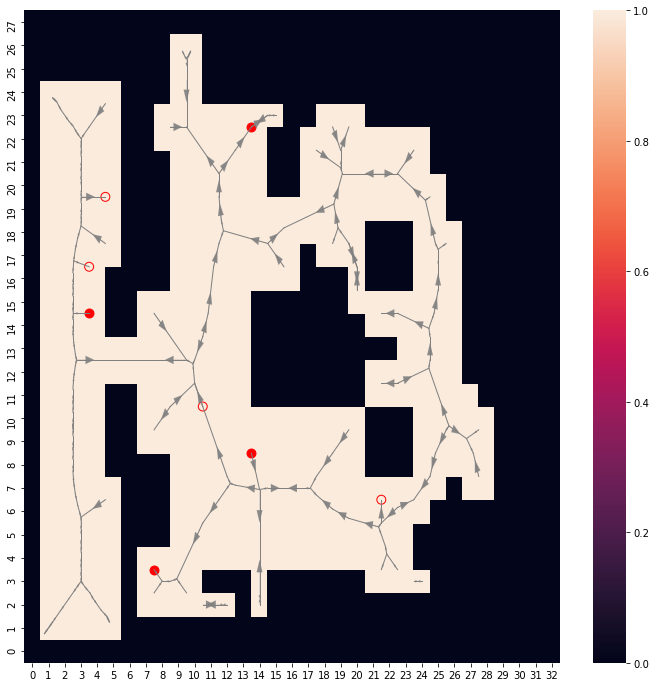

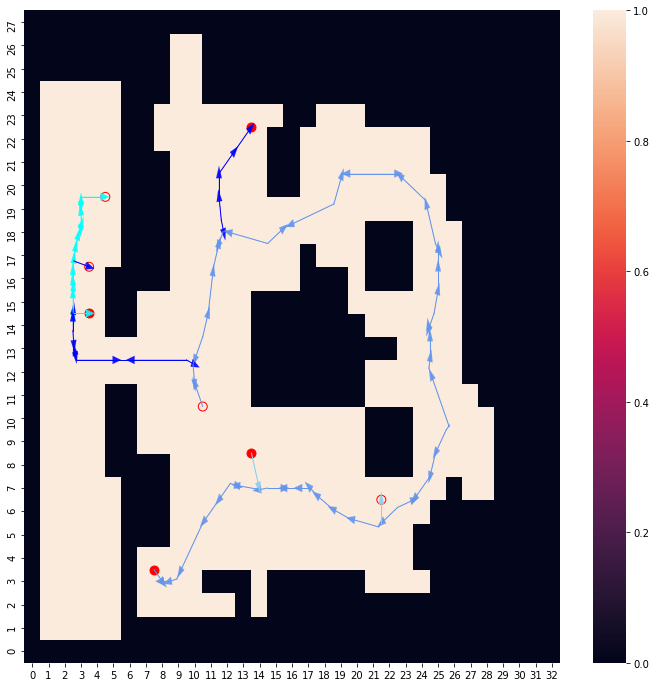

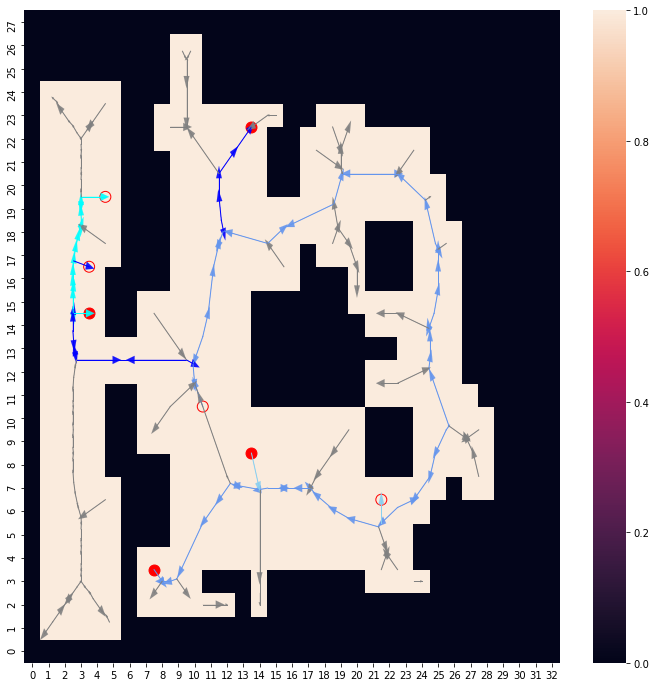

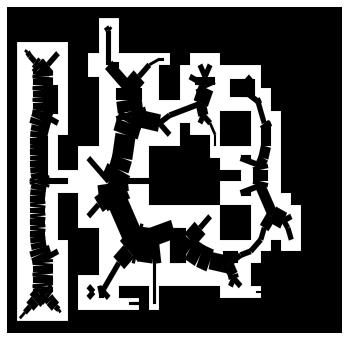

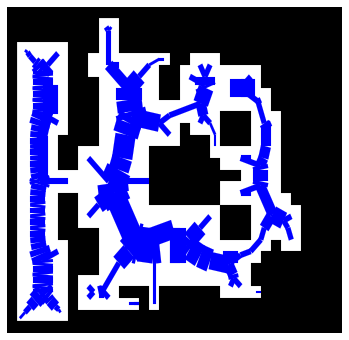

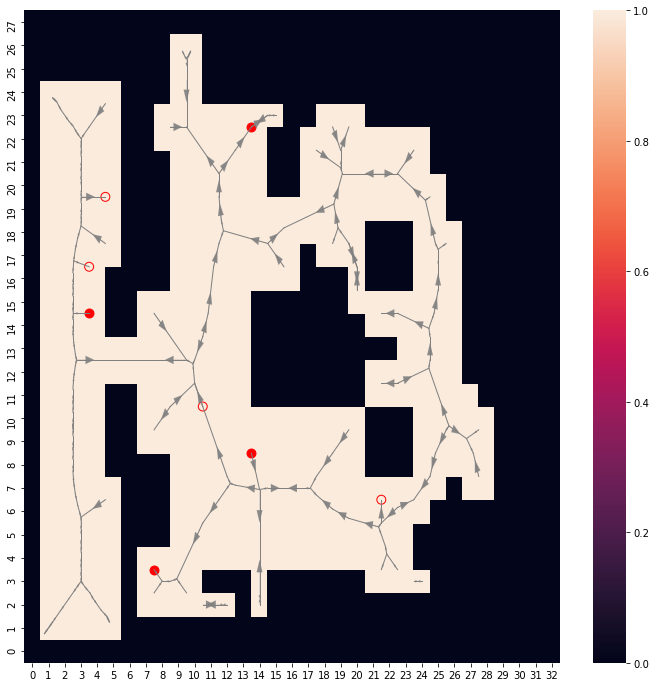

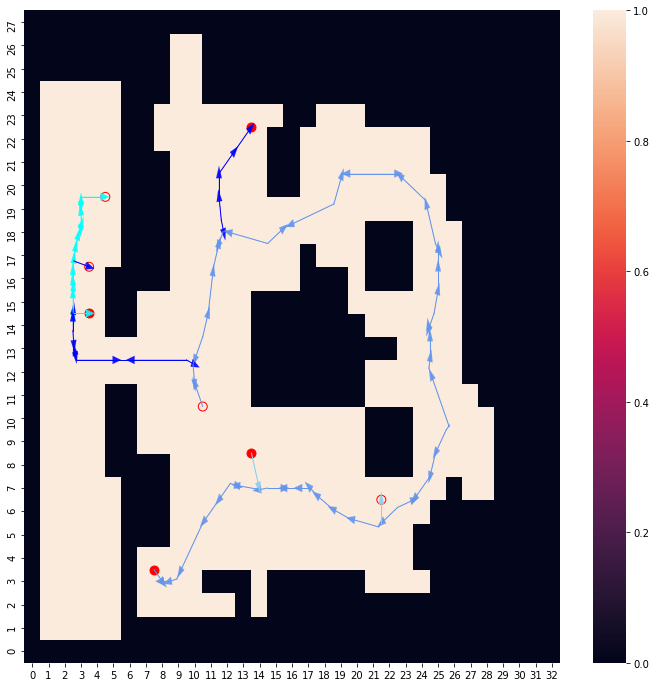

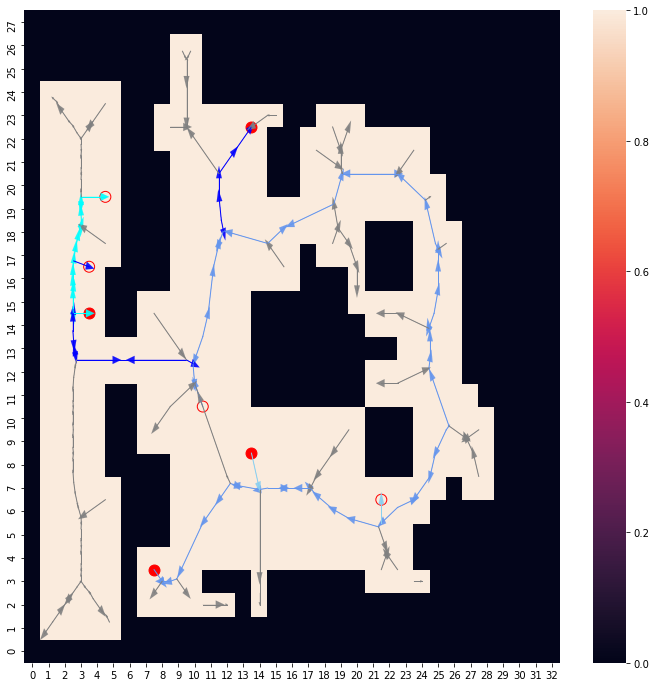

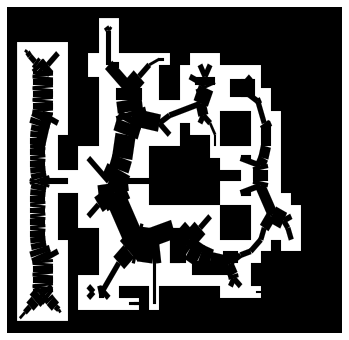

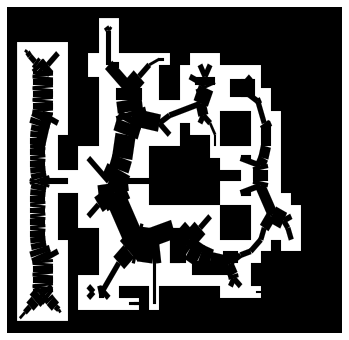

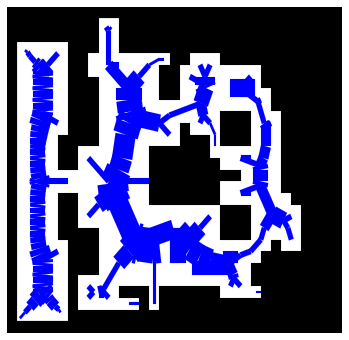

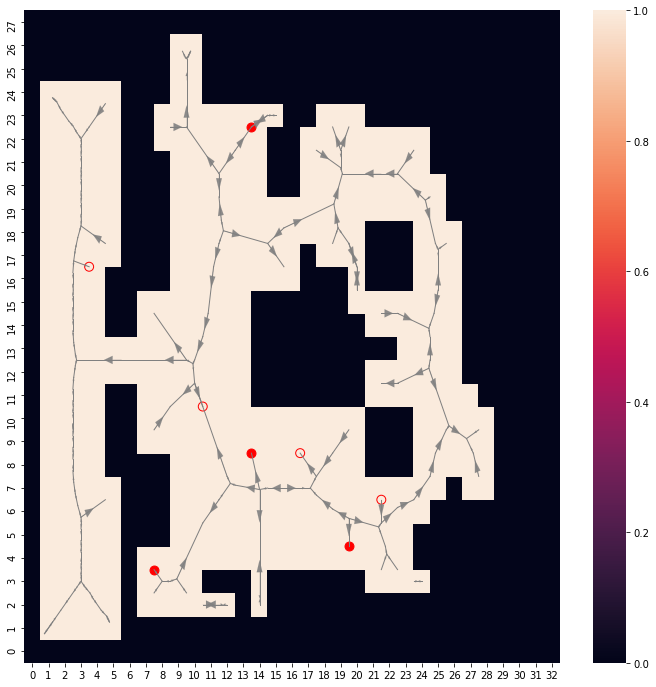

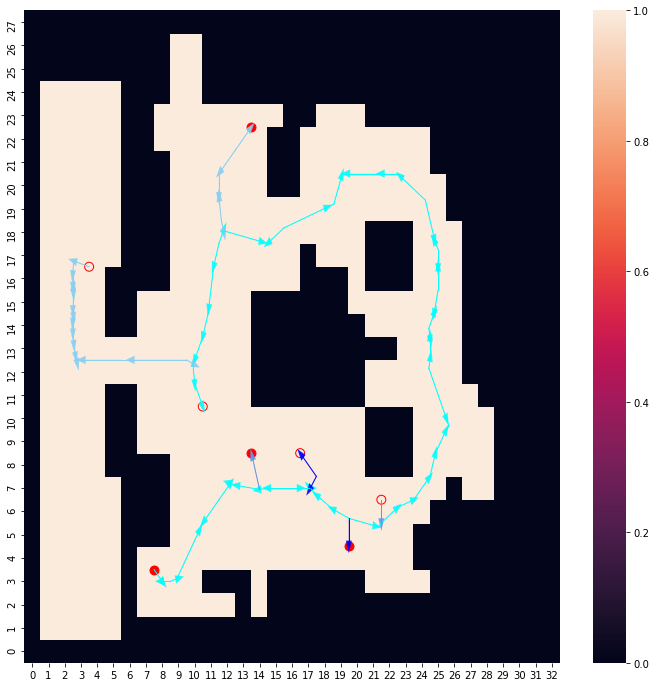

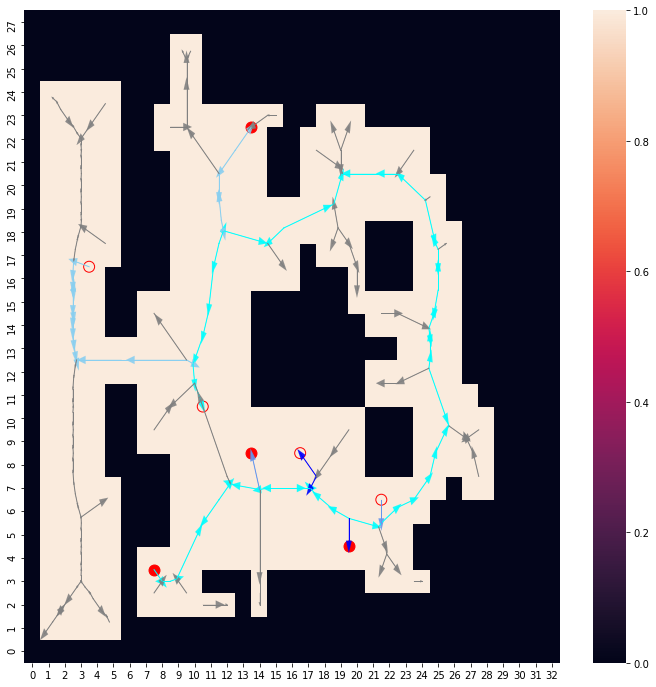

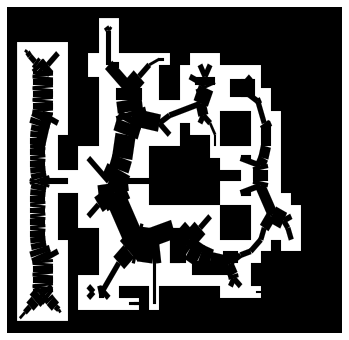

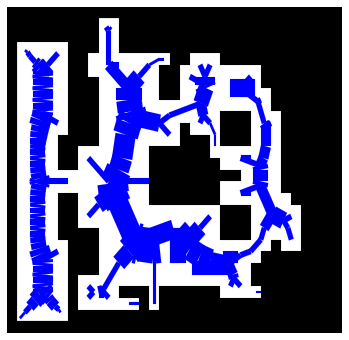

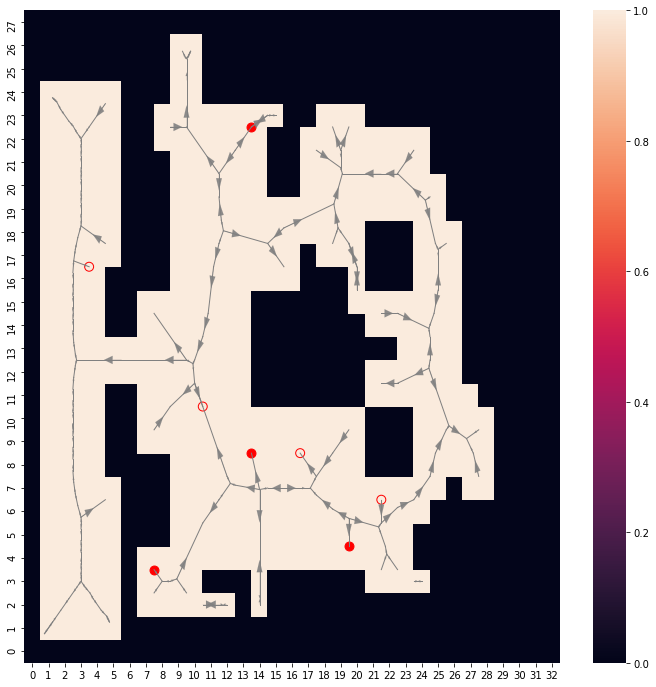

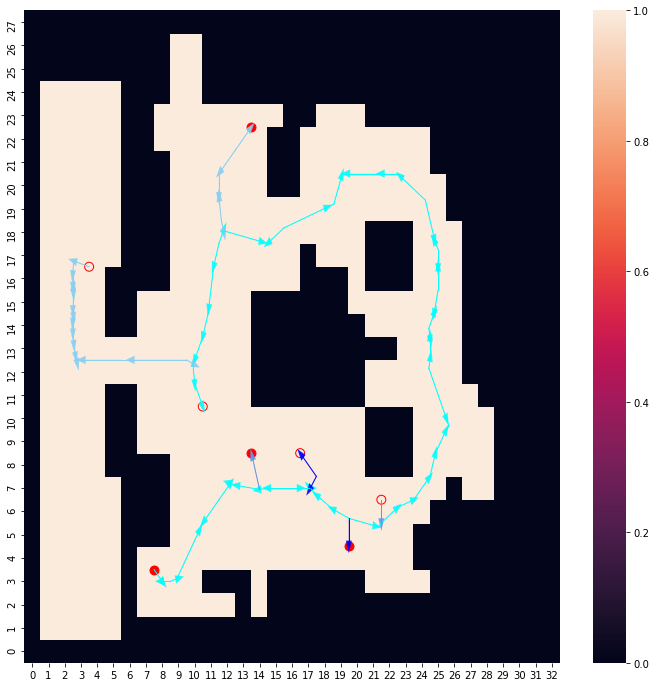

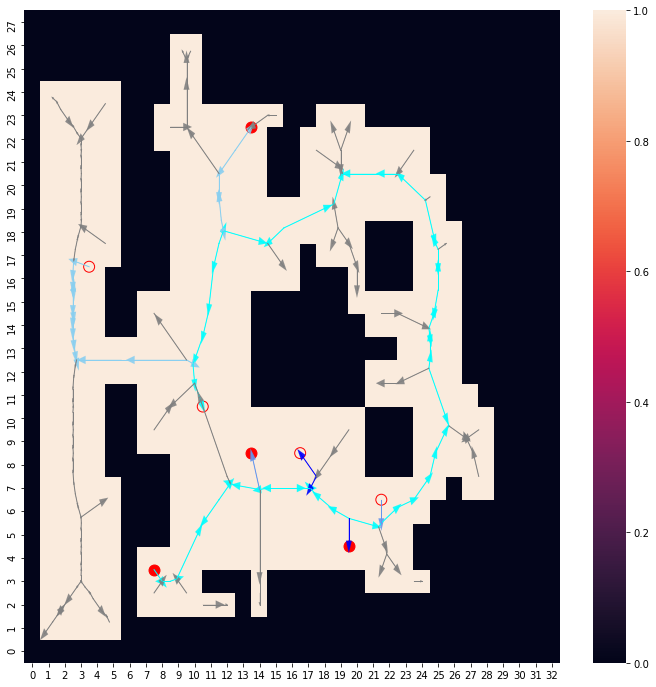

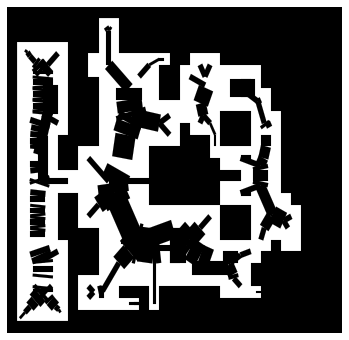

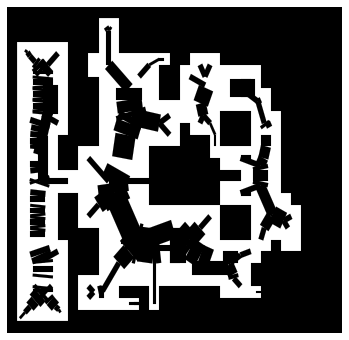

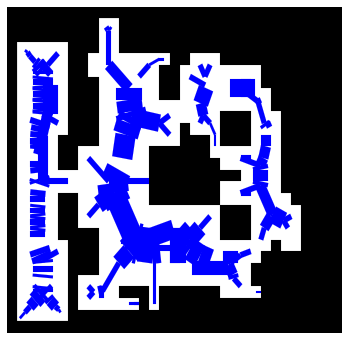

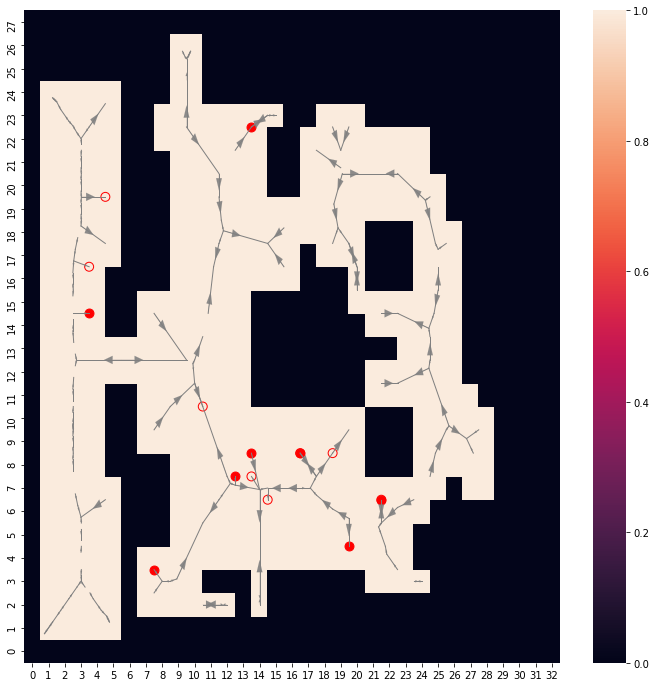

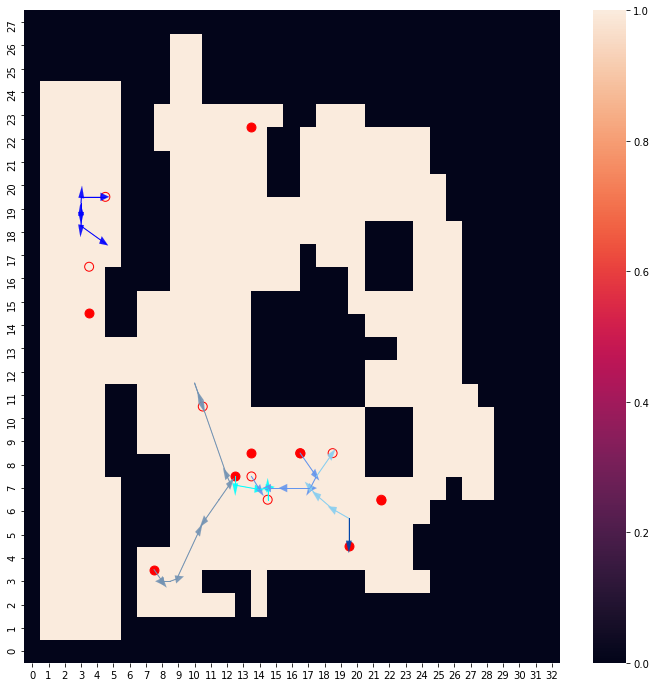

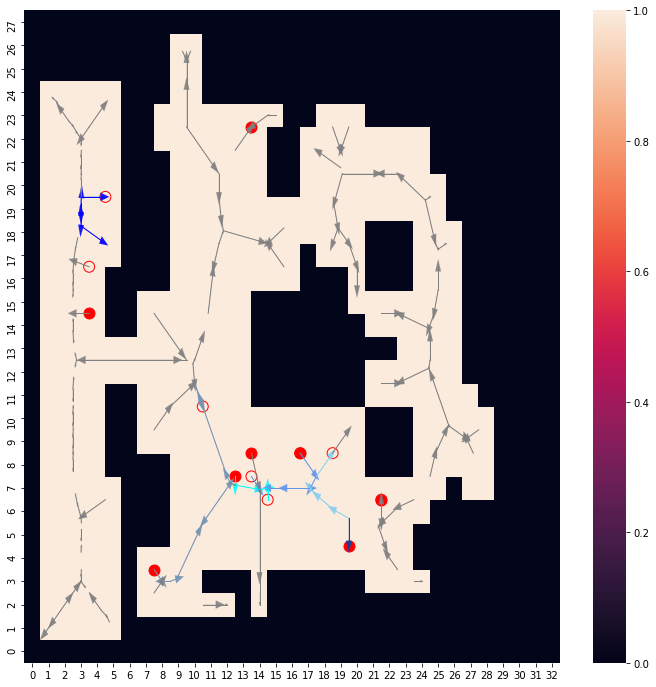

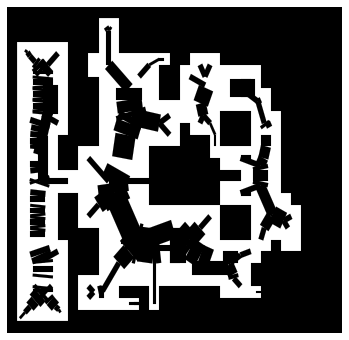

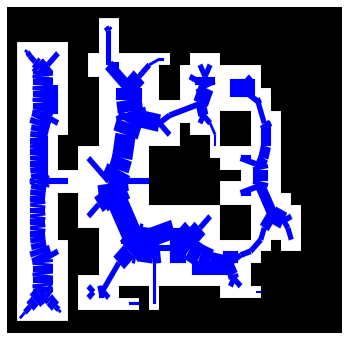

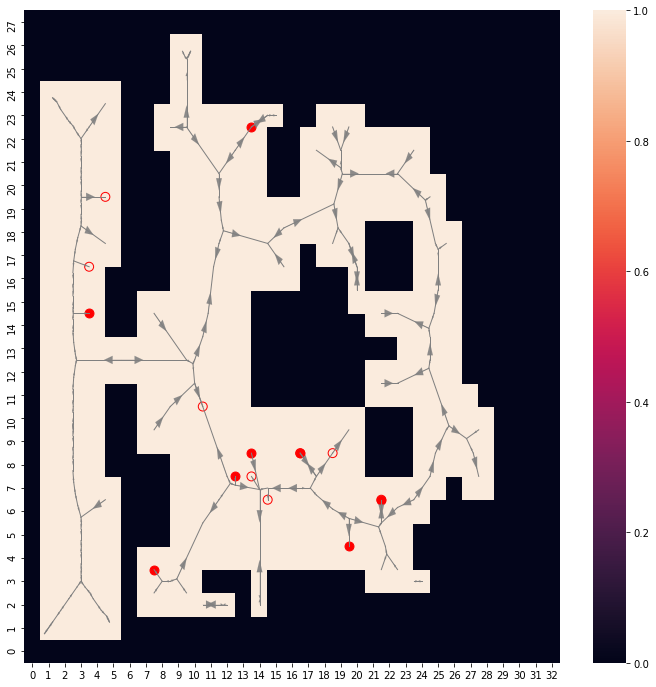

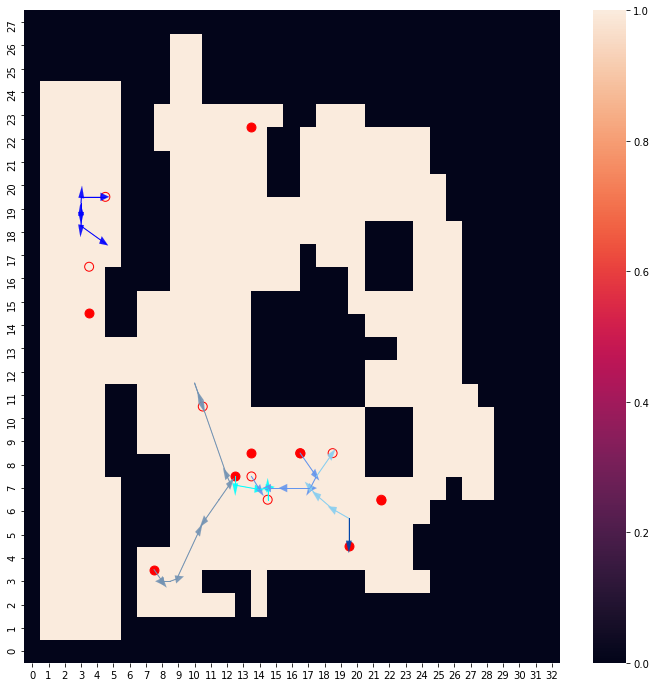

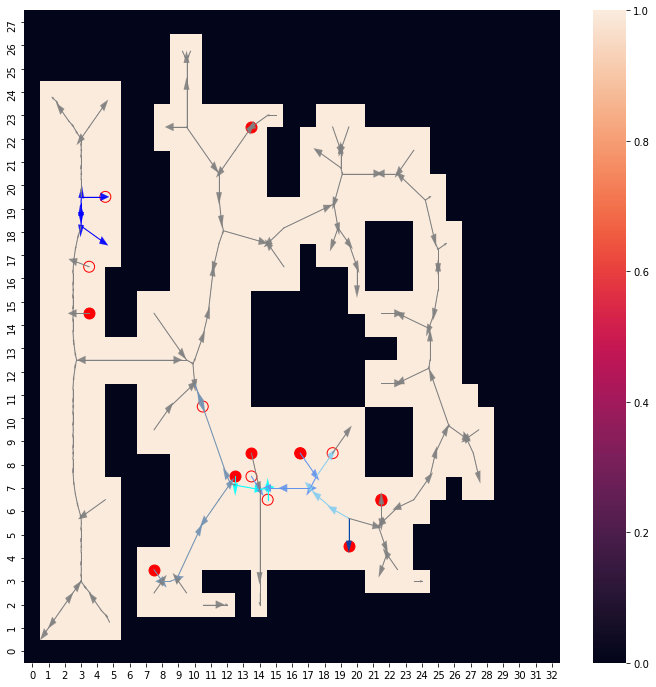

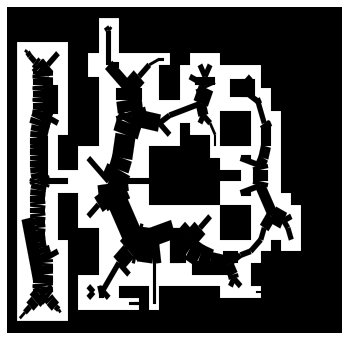

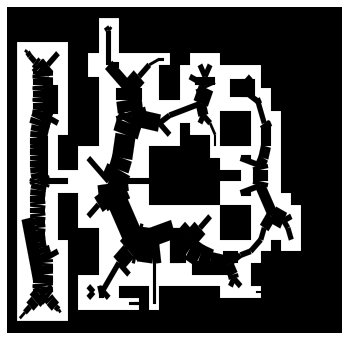

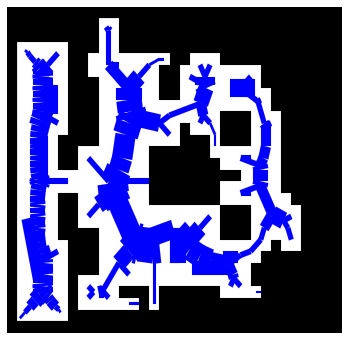

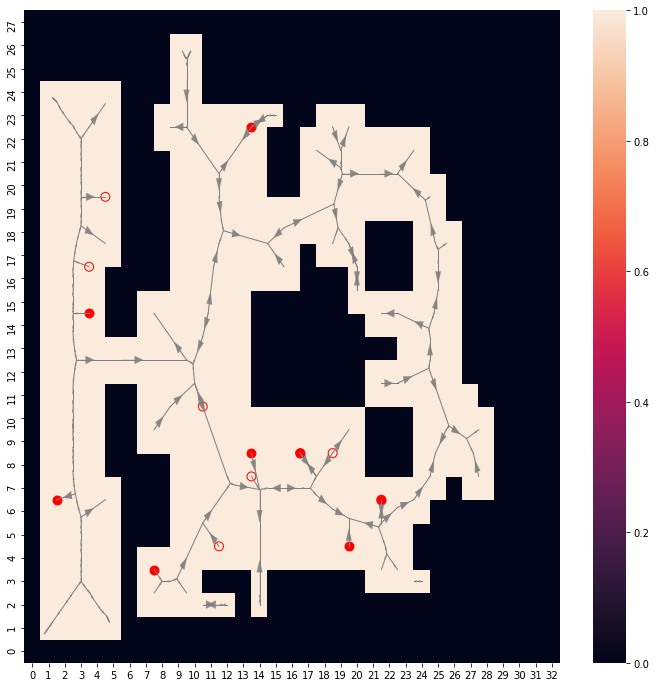

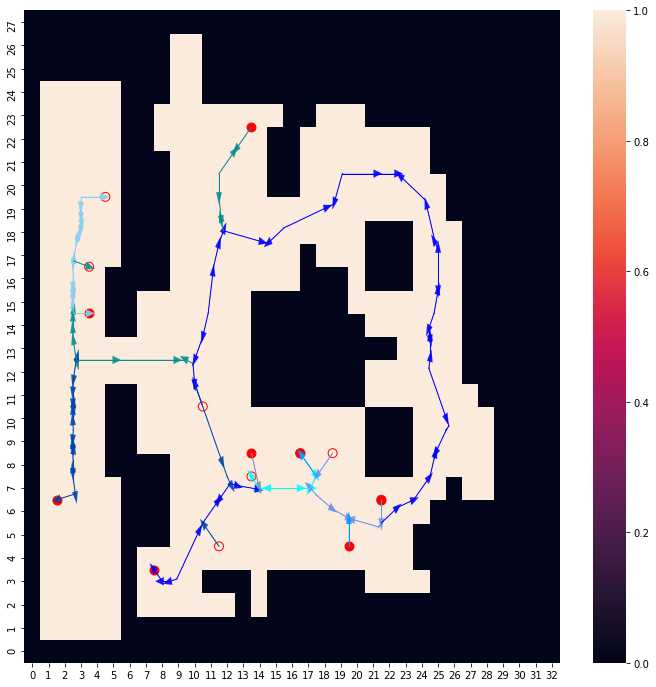

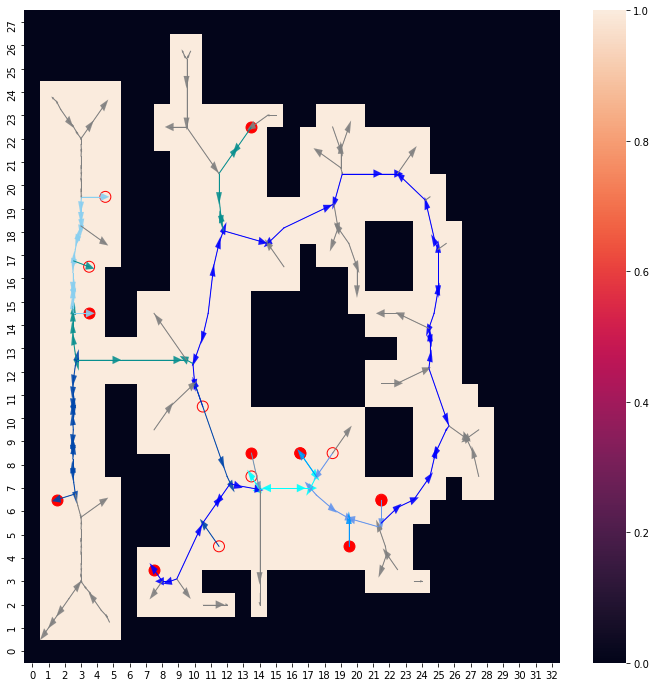

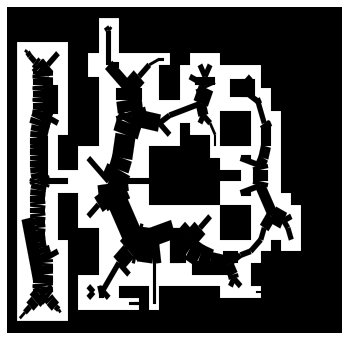

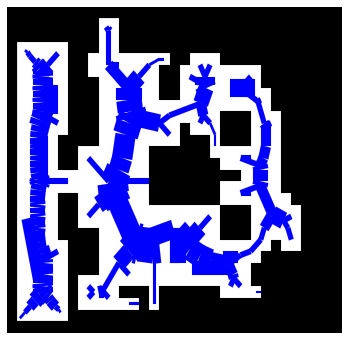

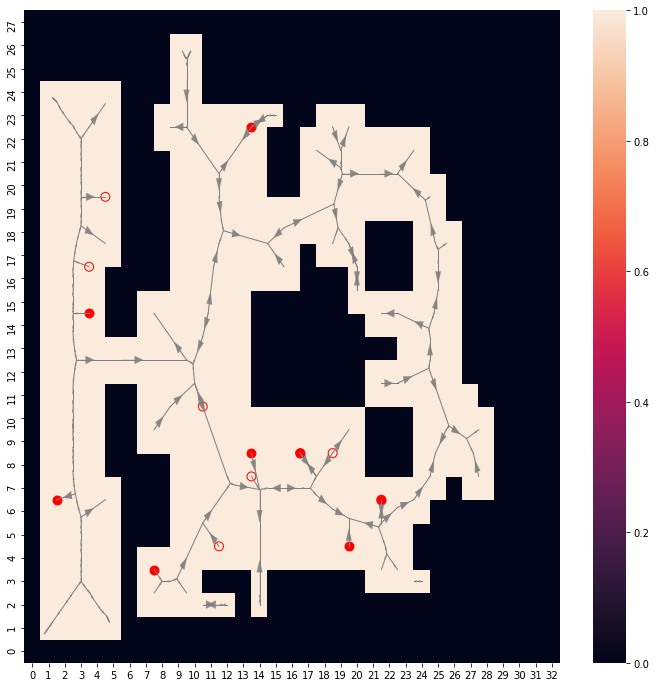

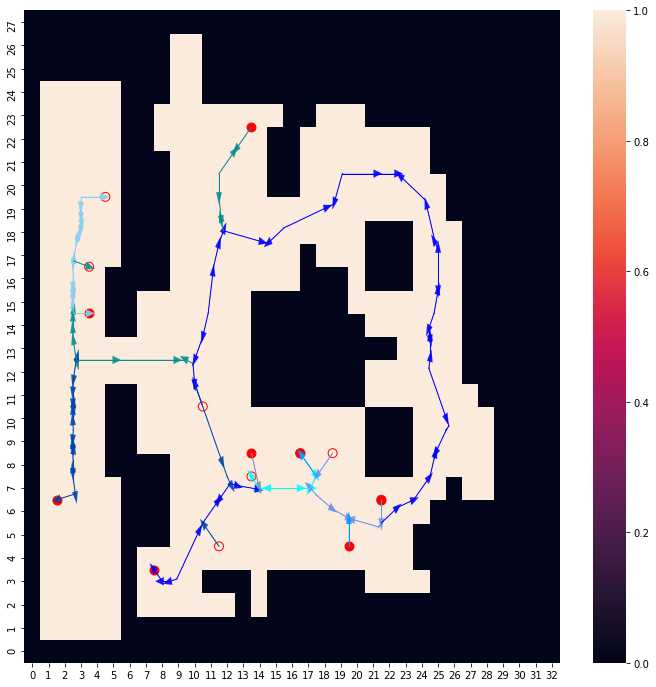

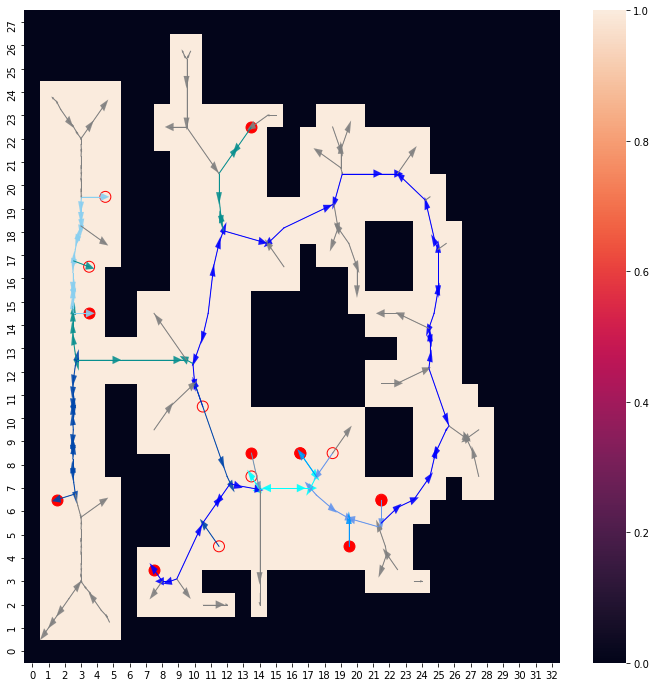

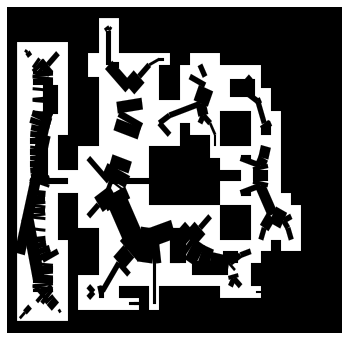

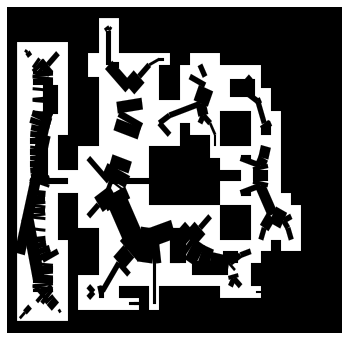

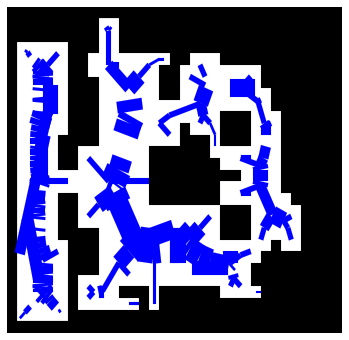

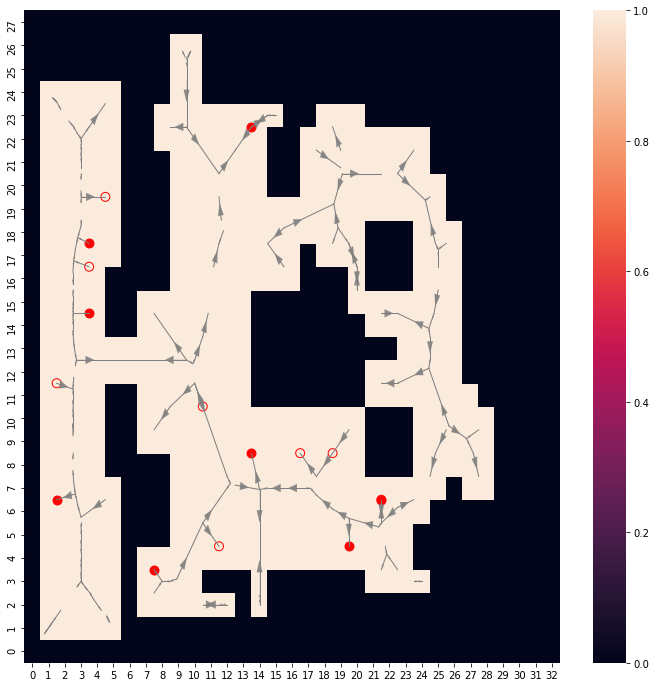

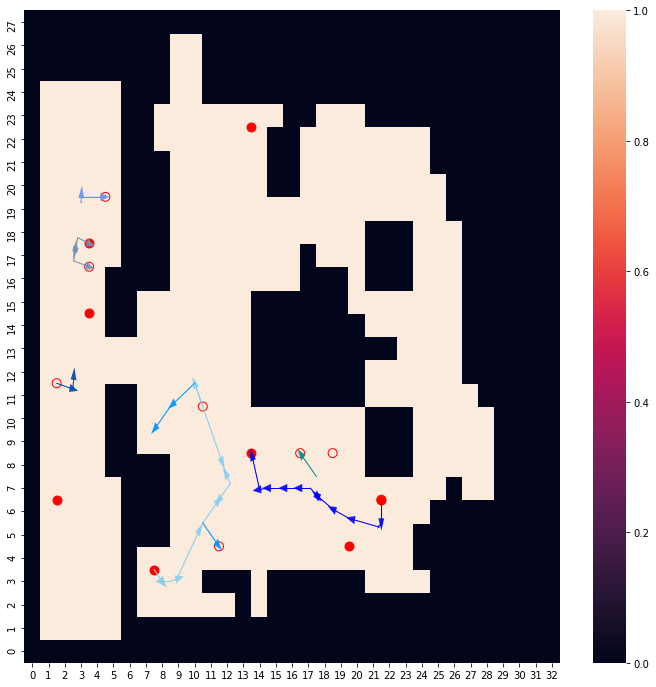

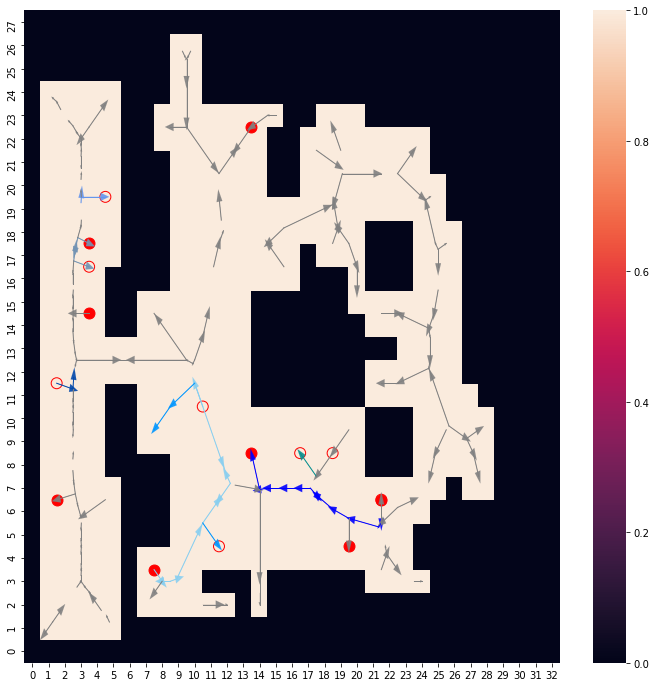

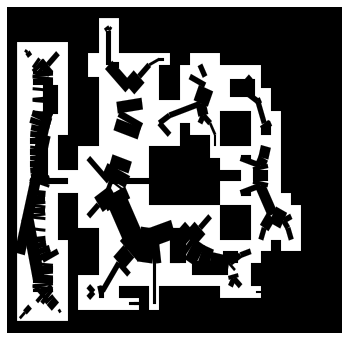

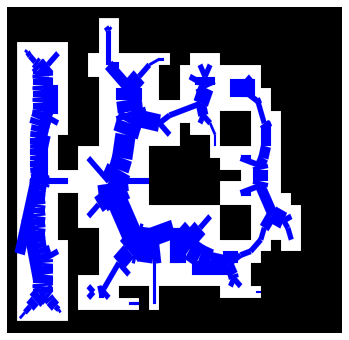

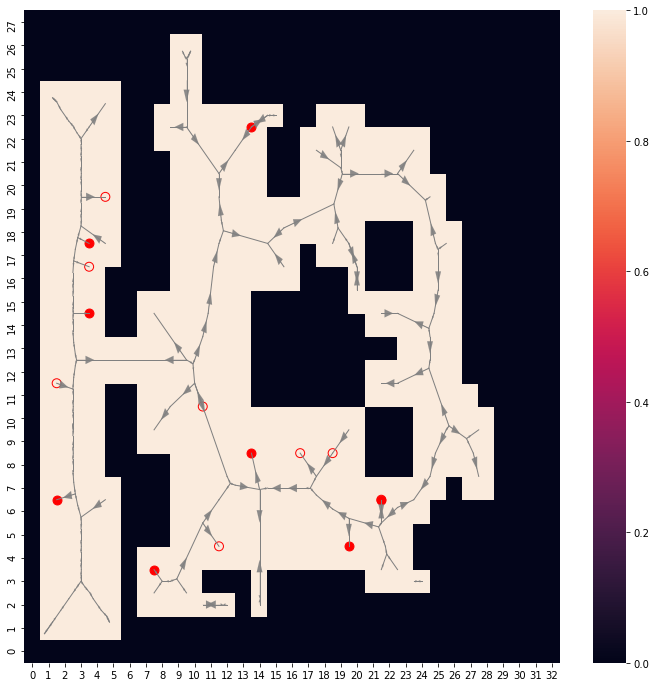

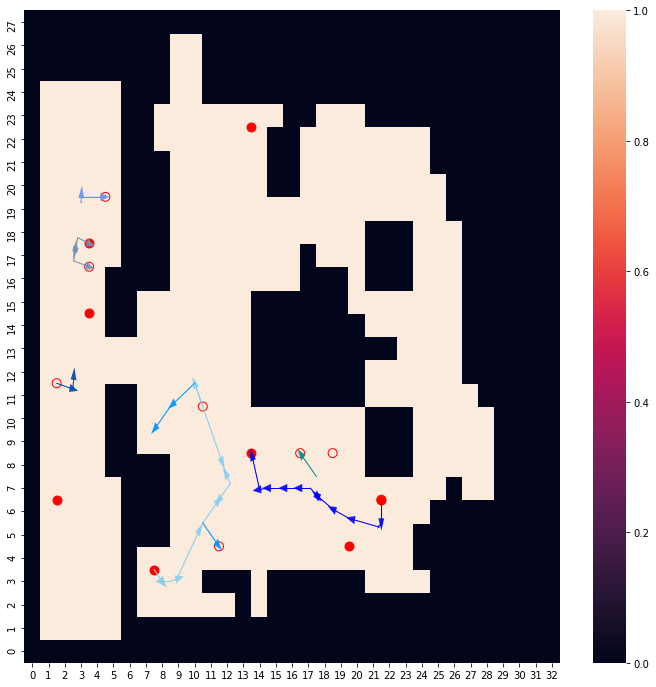

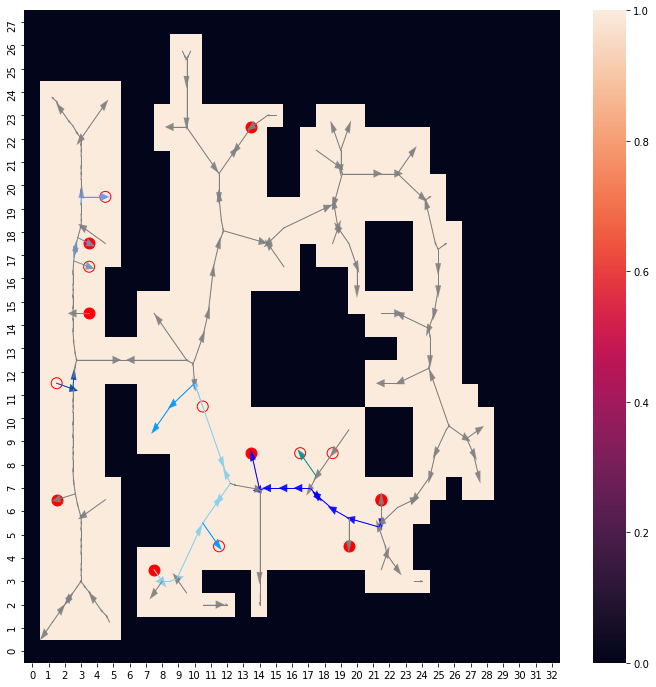

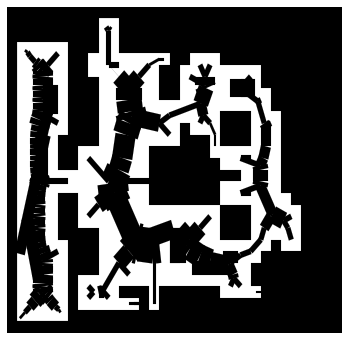

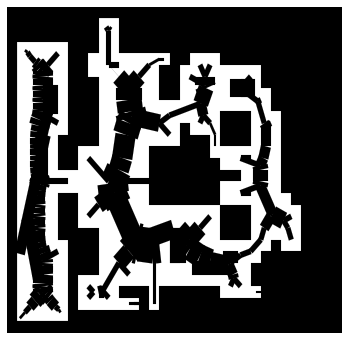

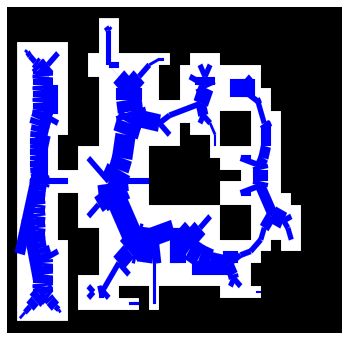

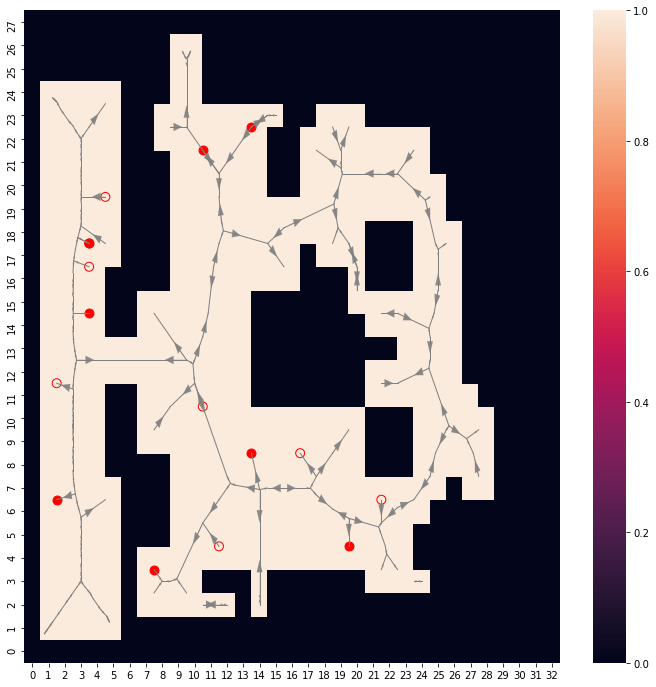

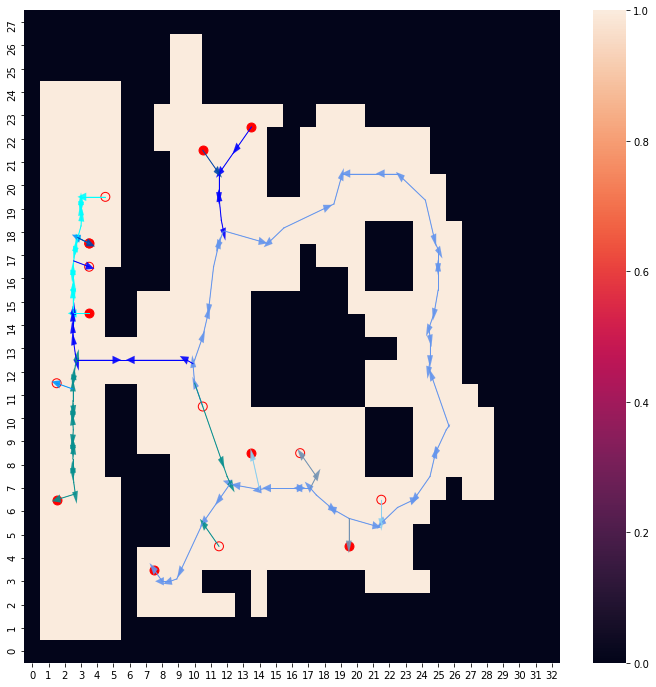

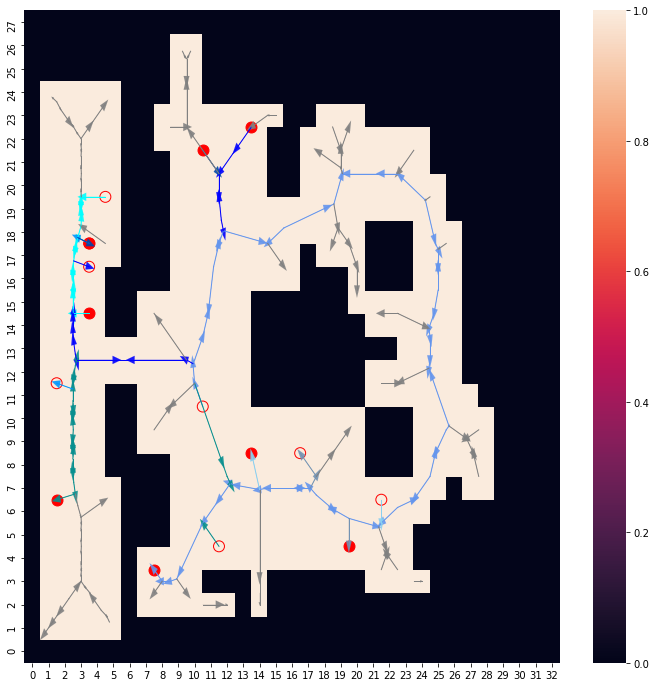

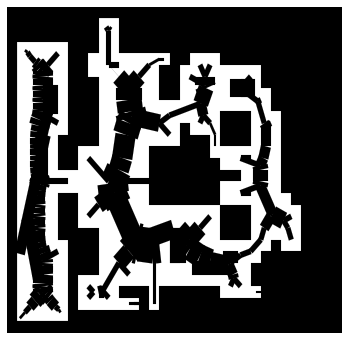

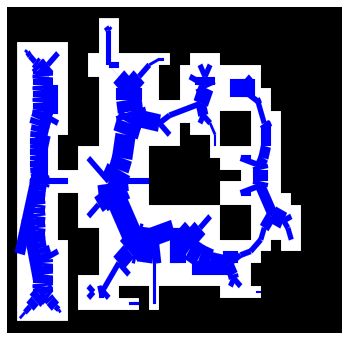

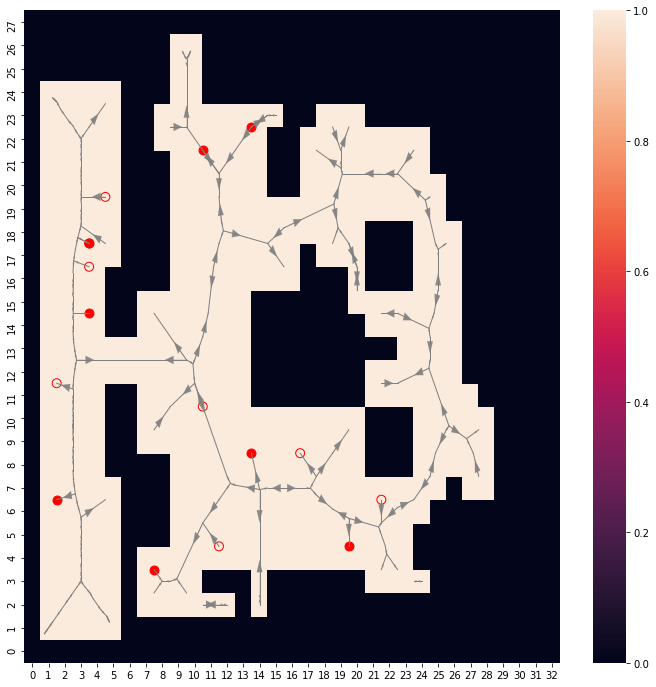

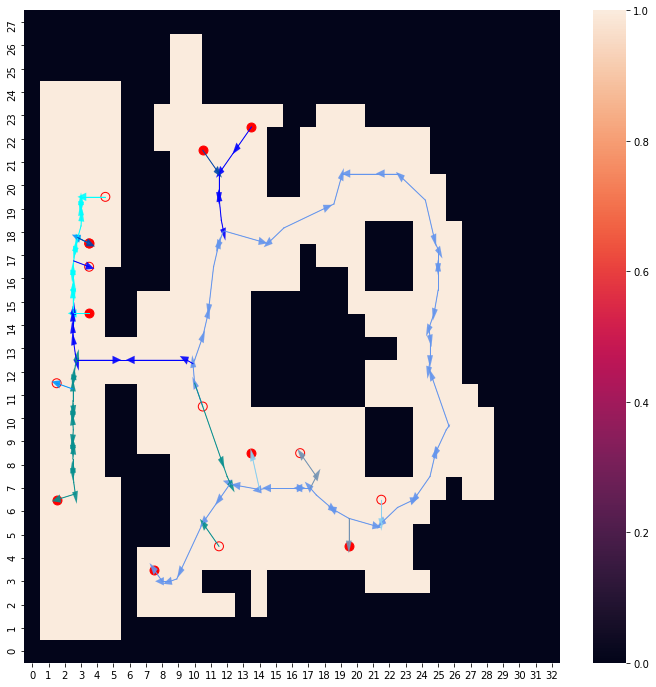

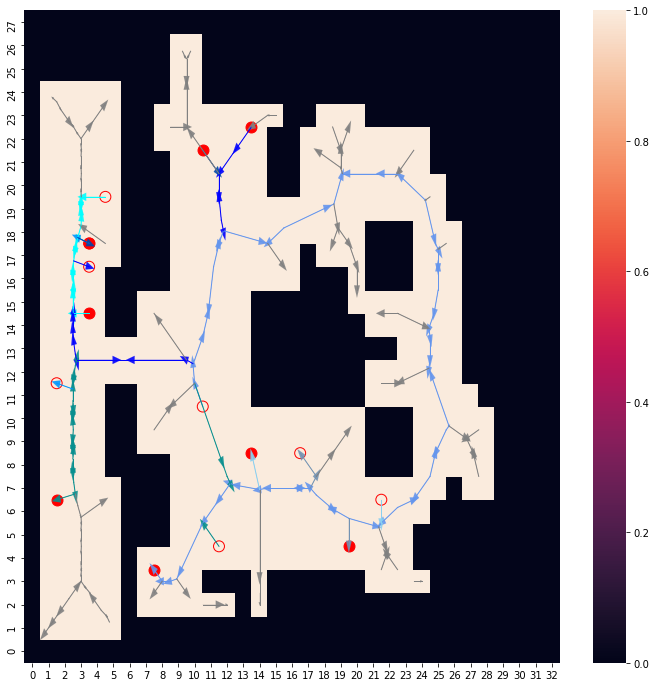

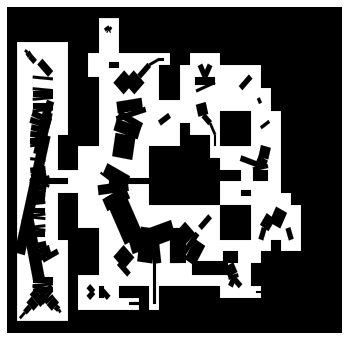

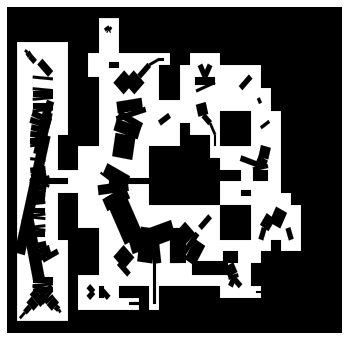

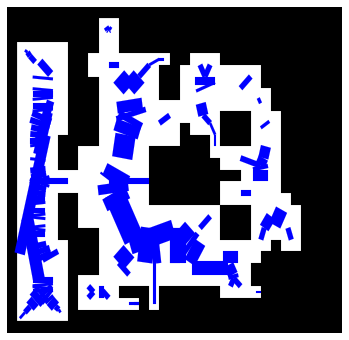

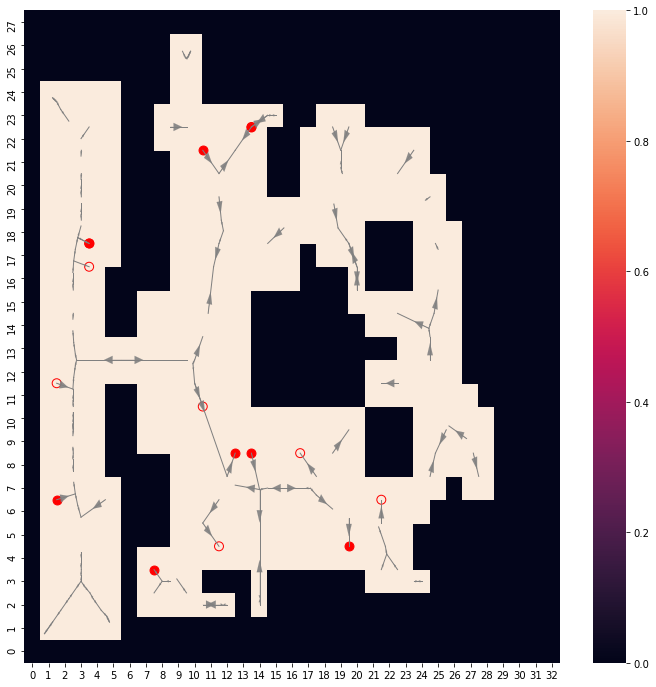

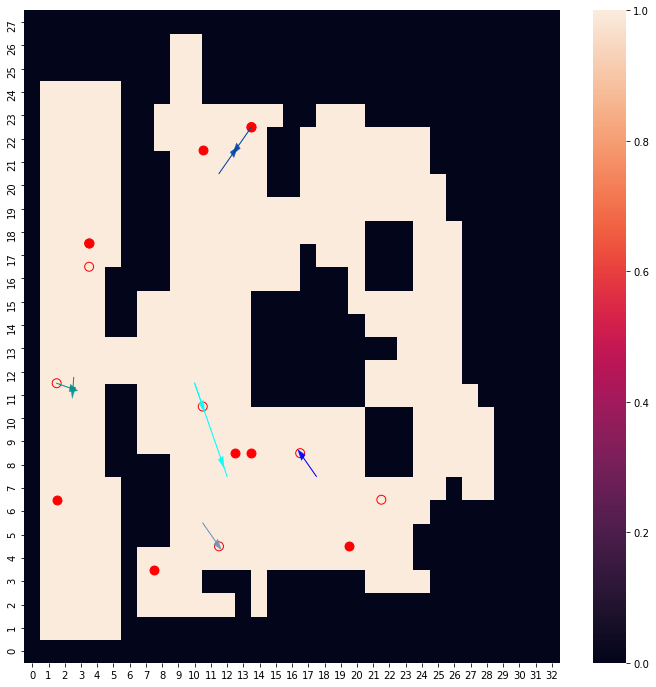

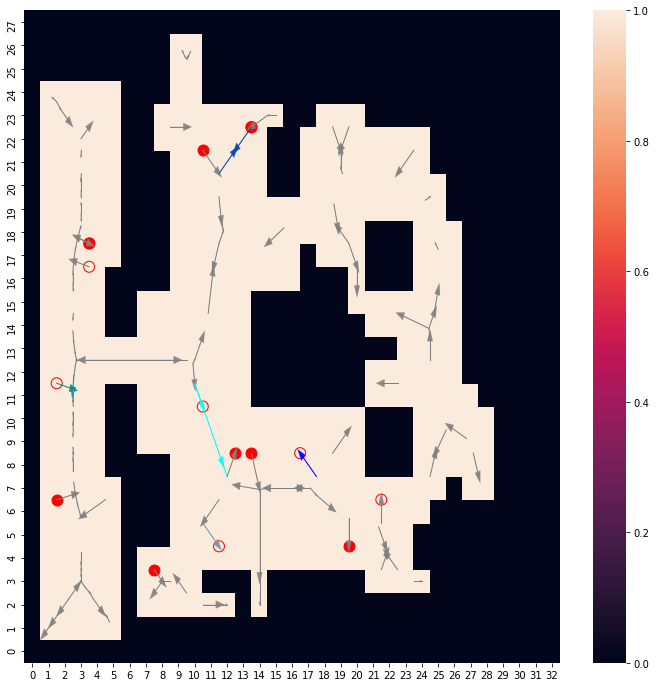

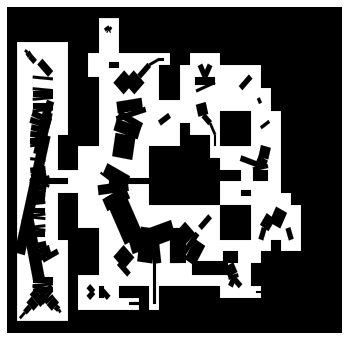

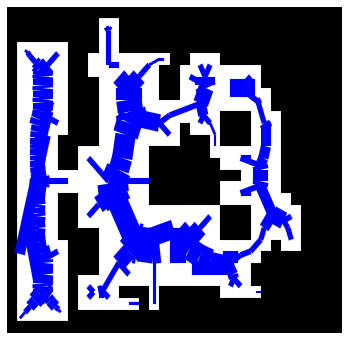

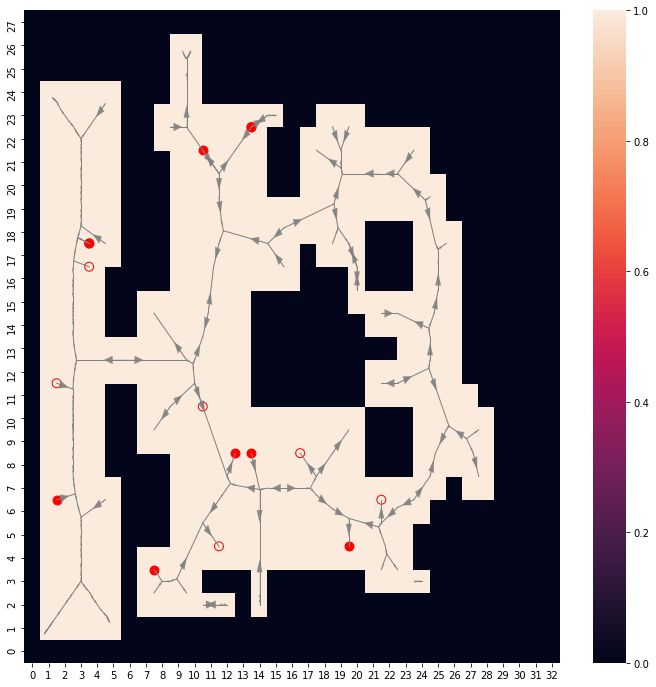

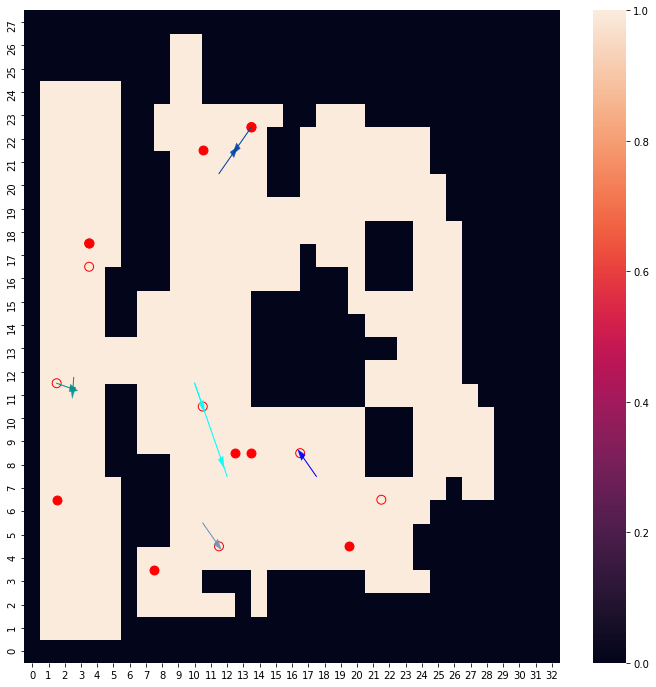

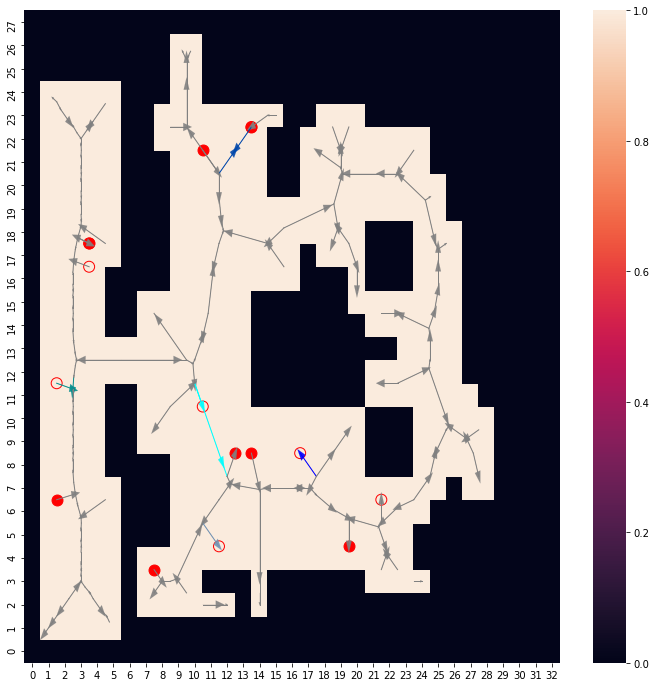

In [7]:
final_result_path =  "./data/Random/final_result.csv"
final_best_path =  "./data/Random/final_result_best.csv"
OBJECTIVE = "Both"
agent_list = [4,8]
# agent_list = [2]
NUM_SEED = 1
mapp = 'lak105d'

for NUM_AGENT in agent_list:
    for DATASET in range (1,6,1):
        seed_list =  np.random.randint(100, size=NUM_SEED)
        print("Seed List", seed_list)
        cost_arr = []
        temp_result = []
        start_time = time.time()
        for SEED in seed_list:
            try:
                overall_path = "./data/Random/"+str(NUM_AGENT)+"agent/Dataset" + str(DATASET) + "/Seed"+ str(SEED) + "/"
                os.makedirs(overall_path)
            except OSError:
                print ("Creation of the directory %s failed" % overall_path)
            else:
                print ("Successfully created the directory %s " % overall_path)

            sample_start = time.time()
            result_fig_path = "./data/Random/"+str(NUM_AGENT)+"agent/Dataset" + str(DATASET) + "/Seed"+ str(SEED) + "/fig.png"
            vordir_fig_pathonly_path = "./data/Random/"+str(NUM_AGENT)+"agent/Dataset" + str(DATASET) + "/Seed"+ str(SEED) + "/vordir_paths.png"
            vordir_fig_alledge_path = "./data/Random/"+str(NUM_AGENT)+"agent/Dataset" + str(DATASET) + "/Seed"+ str(SEED) + "/vordir_alledge.png"
            vordir_fig_acc_path = "./data/Random/"+str(NUM_AGENT)+"agent/Dataset" + str(DATASET) + "/Seed"+ str(SEED) + "/vordir_acc.png"
            vordir_fig_coverage_path = "./data/Random/"+str(NUM_AGENT)+"agent/Dataset" + str(DATASET) + "/Seed"+ str(SEED) + "/vordir_coverage.png"
            vordir_path_path = "./data/Random/"+str(NUM_AGENT)+"agent/Dataset"  + str(DATASET) + "/Seed"+ str(SEED) + "/vordir_path.csv"
            vordir_probability_path = "./data/Random/"+str(NUM_AGENT)+"agent/Dataset" + str(DATASET) + "/Seed"+ str(SEED) + "/vordir_prob.csv"
            # without sub graph
            vordir2_fig_pathonly_path = "./data/Random/"+str(NUM_AGENT)+"agent/Dataset" + str(DATASET) + "/Seed"+ str(SEED) + "/vordir_nosub_paths.png"
            vordir2_fig_alledge_path = "./data/Random/"+str(NUM_AGENT)+"agent/Dataset" + str(DATASET) + "/Seed"+ str(SEED) + "/vordir_nosub_alledge.png"
            vordir2_fig_acc_path = "./data/Random/"+str(NUM_AGENT)+"agent/Dataset" + str(DATASET) + "/Seed"+ str(SEED) + "/vordir_nosub_acc.png"
            vordir2_fig_coverage_path = "./data/Random/"+str(NUM_AGENT)+"agent/Dataset" + str(DATASET) + "/Seed"+ str(SEED) + "/vordir_nosub_coverage.png"
            vordir2_path_path = "./data/Random/"+str(NUM_AGENT)+"agent/Dataset" + str(DATASET) + "/Seed"+ str(SEED) + "/vordir_nosub_path.csv"
            vordir2_probability_path = "./data/Random/"+str(NUM_AGENT)+"agent/Dataset" + str(DATASET) + "/Seed"+ str(SEED) + "/vordir_nosub_prob.csv"
            

            scene = "./input/same_density/"+ mapp +'/dataset/'+str(DATASET)+'_'+ mapp + ".scen"
            scenemap = "./input/same_density/"+ mapp +'/'+ mapp + ".map"
            exp = experiment.Experiment(scenemap=scenemap, scene=scene, objective= OBJECTIVE, num_agent=NUM_AGENT)

            start = time.time()
            probabilities, cost = randVoronoiDirected.random_voronoi_directed(exp, dataset = DATASET, num_agent = NUM_AGENT, seed = SEED)
            end = time.time()
            gather_data_time = end-start
            print("Finish generating data")

            print("Start Visualise")
            # Visualise Results
            output = randVoronoiDirected.get_results(probabilities, exp)
            vordir_paths, vordir_cost, vordir_ft, vordir_u1, vordir_u2, vordir_conwait, vordir_conmax, vordir_conavg, vordir_G0, vordir_G, vordir_thres, vordir_penality = output
            vordir_u2 = getCoverage(exp,vordir_G, directed = True)
            vordir_m = probabilities[-3]
            vordir_c = probabilities[-2]

            # Voronoi Directed With subgraph
            vordir_u2 = getCoverage(exp, vordir_G, directed = True)
            getCoverage(exp,vordir_G, directed = True, save_fig_path=vordir_fig_coverage_path)
            showVorDirSolution(vordir_G, vordir_paths, exp, save_fig_path = vordir_fig_alledge_path)
            showVorDirSolutionPath(vordir_G, 
                                    vordir_paths, 
                                    exp.image, 
                                    exp.nodes, 
                                    exp.start_nodes, 
                                    exp.end_nodes, 
                                    all_path = False, 
                                    path_num = 0,
                                    save_fig_path = vordir_fig_pathonly_path) #path_num variables is unused
            showVorDirSolutionAcc(vordir_G, 
                                    vordir_paths, 
                                    exp.image, 
                                    exp.nodes, 
                                    exp.start_nodes, 
                                    exp.end_nodes, 
                                    all_path = False, 
                                    path_num = 0,
                                    save_fig_path = vordir_fig_acc_path, 
                                    exp=exp)
            
            
            # Voronoi Directed Without subgraph
            probabilities2 = copy.deepcopy(probabilities)
            probabilities2[-1] = 0
            output2 = randVoronoiDirected.get_results(probabilities, exp)
            vordir2_paths, vordir2_cost, vordir2_ft, vordir2_u1, vordir2_u2, vordir2_conwait, vordir2_conmax, vordir2_conavg, vordir2_G0, vordir2_G, vordir2_thres, vordir2_penality = output2
            vordir2_u2 = getCoverage(exp,vordir_G, directed = True)
            with open(vordir2_path_path, 'a+') as f:
                paths = [[idx, exp.nodes[t].x , exp.nodes[t].y] for idx, path in enumerate(vordir2_paths) for t in path]
                paths_pd = pd.DataFrame(paths,columns=['Agent', 'X','Y'])
                pd.DataFrame(paths_pd).to_csv(f, index=None)
            with open(vordir2_probability_path, 'a+') as f:
                pd.DataFrame(probabilities2).to_csv(f, index=None)
            getCoverage(exp,vordir2_G0, directed = True, save_fig_path=vordir2_fig_coverage_path)
            showVorDirSolution(vordir2_G0, vordir2_paths, exp, save_fig_path = vordir2_fig_alledge_path)
            showVorDirSolutionPath(vordir2_G0, 
                                    vordir2_paths, 
                                    exp.image, 
                                    exp.nodes, 
                                    exp.start_nodes, 
                                    exp.end_nodes, 
                                    all_path = False, 
                                    path_num = 0,
                                    save_fig_path = vordir2_fig_pathonly_path) #path_num variables is unused
            showVorDirSolutionAcc(vordir2_G0, 
                                    vordir2_paths, 
                                    exp.image, 
                                    exp.nodes, 
                                    exp.start_nodes, 
                                    exp.end_nodes, 
                                    all_path = False, 
                                    path_num = 0,
                                    save_fig_path = vordir2_fig_acc_path, 
                                    exp=exp)
            
            #save_result
            results = [NUM_AGENT, DATASET, SEED, vordir_cost, 
                           vordir_ft, vordir_u1, vordir_u2, vordir_penality,
                           vordir_conwait, vordir_conmax, vordir_thres, vordir_m, vordir_c,
                           vordir2_cost, vordir2_ft, vordir2_u1, vordir2_u2, vordir2_conwait, vordir2_conmax, vordir2_penality,gather_data_time]
            results_array.append(results)

            cost_arr.append(vordir_cost)
            temp_result.append(results)

            result_pd = pd.DataFrame([results],columns=[ 'NUM_AGENT','Dataset','SEED', 'vordir_cost',
                                                        'vordir_ft', 'vordir_u1', 'vordir_u2', 'vordir_penality',
                                                        'vordir_conwait', 'vordir_conmax', 'vordir_thres', 'vordir_m', 'vordir_c',
                                                        'vordir2_cost', 'vordir2_ft', 'vordir2_u1', 'vordir2_u2', 'vordir2_conwait', 'vordir2_conmax', 'vordir2_penality','Time'])
            with open(final_result_path, 'a+') as f:
                pd.DataFrame(result_pd).to_csv(f, index=None)


        #store min cost results among random seed
        end_time = time.time()
        overall_time = end_time-start_time
        idx = cost_arr.index(min(cost_arr))
        best = temp_result[idx]
        best[-1] = overall_time
        best_result = pd.DataFrame([best],columns=[ 'NUM_AGENT','Dataset','SEED', 'vordir_cost',
                                                    'vordir_ft', 'vordir_u1', 'vordir_u2', 'vordir_penality',
                                                    'vordir_conwait', 'vordir_conmax', 'vordir_thres', 'vordir_m', 'vordir_c',
                                                    'vordir2_cost', 'vordir2_ft', 'vordir2_u1', 'vordir2_u2', 'vordir2_conwait', 'vordir2_conmax', 'vordir2_penality','Time'])
        with open(final_best_path, 'a+') as f:
            pd.DataFrame(best_result).to_csv(f, index=None)

        print("Done")


## Show Result

In [ ]:
pd.DataFrame(results_array,columns=['NUM_AGENT','Dataset','SEED', 'cost',
                                  'vordir_ft','vordir_u1','vordir_u2',
                                  'vordir_max', 'vordir_avg','subgraph', 
                                  'Time'])